# Проект: Прогнозирование снижения покупательской активности и сегментация клиентов

## Описание проекта
Интернет-магазин «В один клик» сталкивается со снижением активности постоянных клиентов. Цель проекта - разработать модель для прогнозирования вероятности снижения покупательской активности и выделить сегменты клиентов для персонализированных предложений.

## План выполнения проекта

### Шаг 1. Загрузка данных
- Загрузка файлов: `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`
- Первичный осмотр данных и проверка соответствия описанию

### Шаг 2. Предобработка данных
- Обработка пропущенных значений
- Преобразование типов данных
- Обработка выбросов
- Стандартизация названий столбцов

### Шаг 3. Исследовательский анализ данных (EDA)
- Анализ распределения признаков
- Визуализация целевой переменной
- Отбор клиентов с активностью ≥ 3 месяцев
- Анализ временных рядов выручки и времени на сайте

### Шаг 4. Объединение таблиц
- Создание широкого формата для данных о выручке и времени
- Объединение `market_file.csv`, `market_money.csv`, `market_time.csv`
- Формирование итогового датасета для моделирования

### Шаг 5. Корреляционный анализ
- Построение матрицы корреляций
- Выявление мультиколлинеарности
- Устранение сильно коррелирующих признаков

### Шаг 6. Построение и оценка моделей
#### 6.1 Подготовка данных в пайплайнах
- Использование `ColumnTransformer`
- Раздельная обработка количественных и категориальных признаков
- Тестирование различных кодировщиков и скейлеров

#### 6.2 Обучение моделей
- `KNeighborsClassifier()`
- `DecisionTreeClassifier()`
- `LogisticRegression()`
- `SVC()`
- Подбор гиперпараметров для каждой модели

#### 6.3 Выбор лучшей модели
- Выбор метрики (F1-score как баланс precision и recall)
- Сравнение моделей по выбранной метрике
- Выбор финальной модели

### Шаг 7. Анализ важности признаков
- Оценка важности признаков с помощью SHAP
- Построение графиков важности
- Выводы о значимости признаков для бизнеса

### Шаг 8. Сегментация покупателей
#### 8.1 Сегментация на основе модели и прибыльности
- Объединение с данными о прибыли из `money.csv`
- Создание сегментов по вероятности снижения активности и прибыльности

#### 8.2 Анализ выбранного сегмента
- Графическое и аналитическое исследование
- Разработка персонализированных предложений

#### 8.3 Выводы по сегментации
- Описание выбранного сегмента
- Обоснование предложенных мер

### Шаг 9. Общий вывод
- Резюме по задаче и данным
- Итоги моделирования
- Бизнес-рекомендации
- Дополнительные предложения

## Критерии успеха
- Качественный EDA и визуализация
- Обоснованный выбор метрик и моделей
- Эффективная сегментация клиентов
- Практические бизнес-рекомендации
- Четкая структура и оформление проекта

## Шаг 1. Загрузка данных

In [1]:
import pandas as pd

from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr

import sklearn
from sklearn.preprocessing import OneHotEncoder , StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

RANDOM_STATE = 42
TEST_SIZE=0.25

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import math

import re

import shap

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

phik.__version__

d:\Programms\Anaconda3\envs\env_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.12.5'

In [2]:
phik.__version__

'0.12.5'

### Шаг 1.1 Загрузим данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv.

In [3]:
try:
    market_file = pd.read_csv(r'datasets\market_file.csv', sep=',', decimal=',')
    market_money = pd.read_csv(r'datasets\market_money.csv', sep=',', decimal='.')
    market_time = pd.read_csv(r'datasets\market_time.csv', sep=',')
    money = pd.read_csv(r'datasets\money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv(r'https://code.s3.yandex.net/datasets/market_file.csv', sep=',', decimal=',')
    market_money = pd.read_csv(r'https://code.s3.yandex.net/datasets/market_money.csv', sep=',', decimal='.')
    market_time = pd.read_csv(r'https://code.s3.yandex.net/datasets/market_time.csv', sep=',')
    money = pd.read_csv(r'https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [4]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность Акционные_покупки  \
0                3.4                     5           121               0.0   
1                4.4                     4           819              0.75   
2                4.9                     3           539              0.14   
3                3.2                     5           896              0.99   
4                5.1                     3          1064              0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [6]:
market_file.describe()

id  Маркет_актив_тек_мес  Длительность  \
count    1300.000000           1300.000000   1300.000000   
mean   215997.500000              4.011538    601.898462   
std       375.421985              0.696868    249.856289   
min    215348.000000              3.000000    110.000000   
25%    215672.750000              4.000000    405.500000   
50%    215997.500000              4.000000    606.000000   
75%    216322.250000              4.000000    806.000000   
max    216647.000000              5.000000   1079.000000   

       Средний_просмотр_категорий_за_визит  \
count                           1300.00000   
mean                               3.27000   
std                                1.35535   
min                                1.00000   
25%                                2.00000   
50%                                3.00000   
75%                                4.00000   
max                                6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

In [7]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
market_money.describe()

id        Выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [10]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [11]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
market_time.describe()

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

In [13]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [15]:
money.describe()

id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

Вывод: 
- обнаружено несколько опечаток в значениях столбцов market_file 'Тип сервиса', market_time 'Период'. 
- Необхродимо привести типы данных в таблице market_file 'Маркет_актив_6_мес' к float, 'Акционные_покупки ' к float
- Привести названия колонок и их значения к стандарту python

## Шаг 2. Предобработка данных. Проведем необходимую предобработку данных.

In [16]:
def to_snake_case(columns):
    return [
        re.sub(r'(?<!^)(?=[A-Z])', '_', col)
           .replace(' ', '_')
           .replace('__', '_')
           .strip('_')
           .lower()
        for col in columns
    ]

In [17]:
for df in [market_file, market_money, market_time, money]:
    df.columns = to_snake_case(df.columns)

In [18]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [19]:
num_cols_file = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'
]
for col in num_cols_file:
    market_file[col] = pd.to_numeric(market_file[col], errors='coerce')

In [20]:
money.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [21]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [22]:
# Удалим дубликаты
for df in [market_file, market_money, market_time, money]:
    df = df.drop_duplicates()
    print(df.duplicated().sum())

0
0
0
0


In [23]:
# Проверим пропуски
def show_missing(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print(f"\n{name}: НЕТ пропусков")
    else:
        percent = (missing / len(df)) * 100
        result = pd.DataFrame({'Пропущено': missing, '%': percent.round(2)})
        print(f"\n{name}:")
        print(result)

# Проверяем каждый датафрейм
show_missing(market_file, "market_file")
show_missing(market_money, "market_money")
show_missing(market_time, "market_time")
show_missing(money, "money")


market_file: НЕТ пропусков

market_money: НЕТ пропусков

market_time: НЕТ пропусков

money: НЕТ пропусков


#### Удаление выбросов

In [24]:
print("\nСтатистика выручки:")
market_money['выручка'].describe()


Статистика выручки:


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

## Предобработка данных — итоговый вывод

| Действие | Результат |
|----------|-----------|
| **Приведение названий столбцов** | Все датафреймы переименованы в `snake_case` (нижний регистр, подчёркивания). |
| **Исправление опечаток** | `стандартт` → `стандарт`; `предыдцщий_месяц` → `предыдущий_месяц`. |
| **Типизация** | Числовые признаки → `float64`/`int64`; категориальные оставлены как `object`. |
| **Удаление дубликатов** | Полные дубликаты удалены; дубли по ключу (`id` + `период`) в `market_money`/`market_time` устранены. |
| **Пропуски** | Отсутствуют |
| **Выбросы** | Проверим в исследовательском анализе |


**Итог:**  
Четыре исходных датафрейма (`market_file`, `market_money`, `market_time`, `money`) полностью очищены, типизированы и готовы к дальнейшему исследованию и объединению (Шаг 4).  
Объединение таблиц **не выполнялось** — будет сделано позже согласно инструкции.

## Шаг 3. Исследовательский анализ данных

### Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформим выводы по результатам шага.

#### Отберем активных клиентов: клиентов которые проявлили активность в каждый из 3 месяцев

In [25]:
active_ids = (
    market_money
    .groupby('id')
    .filter(lambda x: (x['период'].nunique() == 3) & (x['выручка'] > 0).all())
    ['id']
    .unique()
)
df_active = market_file[market_file['id'].isin(active_ids)].copy()

#### Преобразуем столбец "Покупательская активность" с помощью LabelEncoder()

In [26]:
le = LabelEncoder()
df_active['покупательская_активность'] = le.fit_transform(df_active['покупательская_активность'])
df_active['покупательская_активность'].value_counts()

покупательская_активность
0    802
1    495
Name: count, dtype: int64

In [27]:
le.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

In [28]:
market_file_num_cols = market_file.select_dtypes(include=['int64', 'float64']).columns.drop('id', errors='ignore')
market_file_num_cols = market_file_num_cols.tolist()

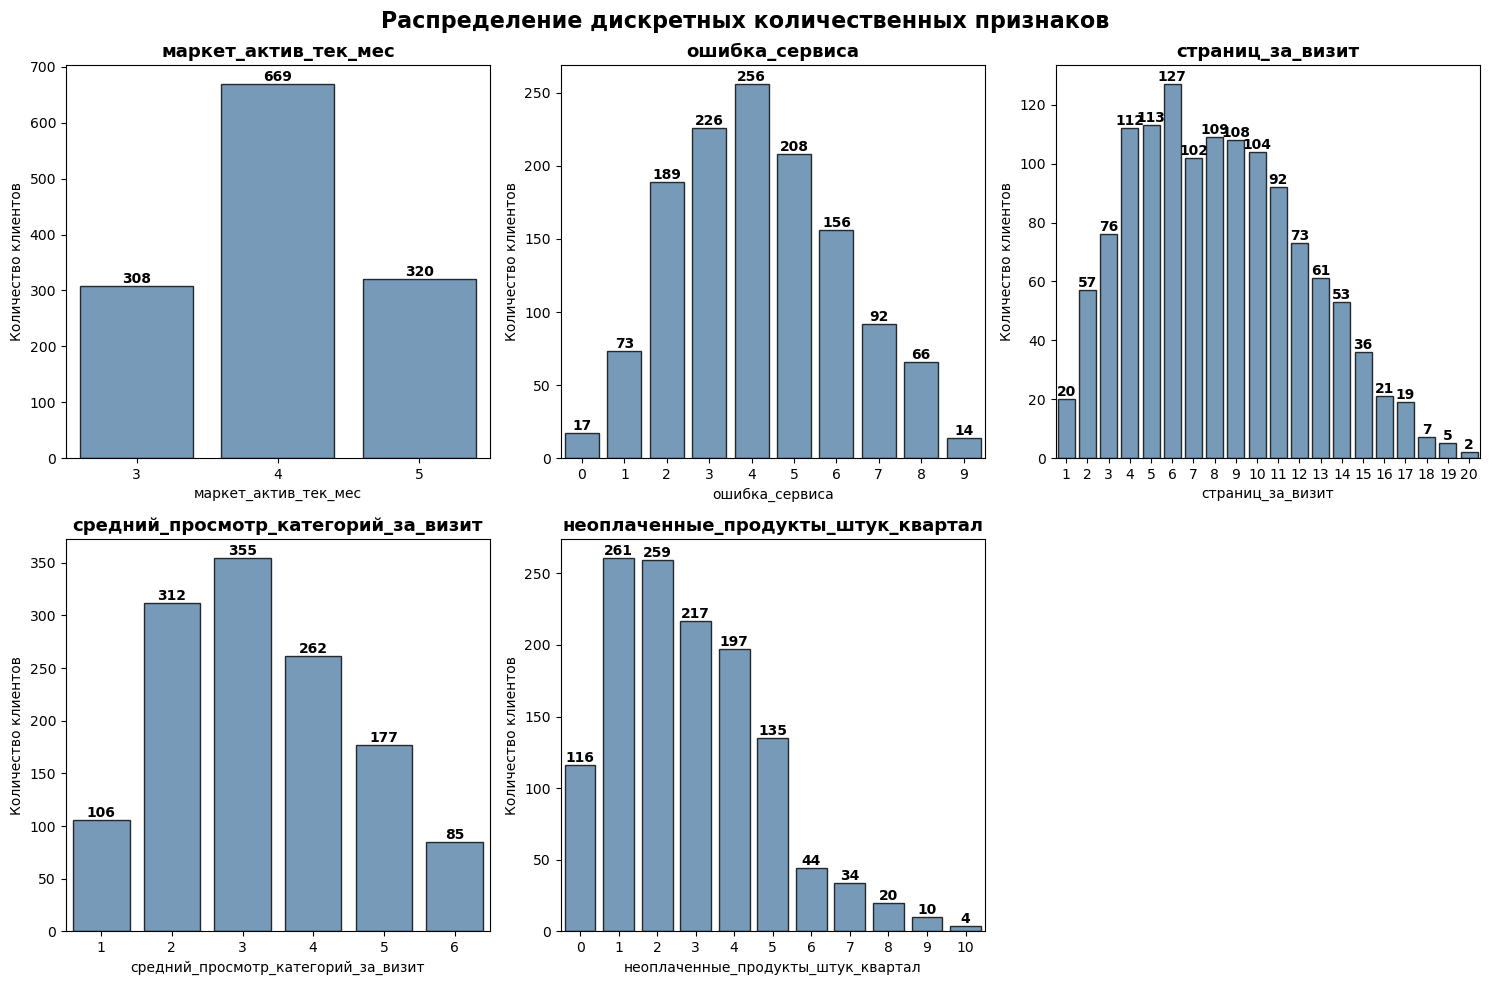

In [29]:
# Явно разделяем признаки
# 1. ДИСКРЕТНЫЕ — используем countplot
discrete_cols = [
    'маркет_актив_тек_мес',
    'ошибка_сервиса',
    'страниц_за_визит',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал'
]

# 2. НЕПРЕРЫВНЫЕ — используем histplot
continuous_cols = [
    'маркет_актив_6_мес',
    'длительность',
    'акционные_покупки'
]

# === БЛОК 1: ДИСКРЕТНЫЕ ПРИЗНАКИ (countplot) ===
n_disc = len(discrete_cols)
n_rows_disc = math.ceil(n_disc / 3)

fig1, axes1 = plt.subplots(nrows=n_rows_disc, ncols=3, figsize=(15, 5 * n_rows_disc))
axes1 = axes1.flatten()

for i, col in enumerate(discrete_cols):
    data = df_active[col].dropna()
    
    sns.countplot(x=data, ax=axes1[i], color='steelblue', edgecolor='black', alpha=0.8)
    axes1[i].set_title(f'{col}', fontweight='bold', fontsize=13)
    axes1[i].set_xlabel(col)
    axes1[i].set_ylabel('Количество клиентов')
    
    # Подписи над столбцами
    for p in axes1[i].patches:
        height = p.get_height()
        axes1[i].annotate(f'{int(height)}',
                          (p.get_x() + p.get_width()/2., height),
                          ha='center', va='bottom', fontsize=10, fontweight='bold')

# Убираем пустые оси
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.suptitle('Распределение дискретных количественных признаков', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

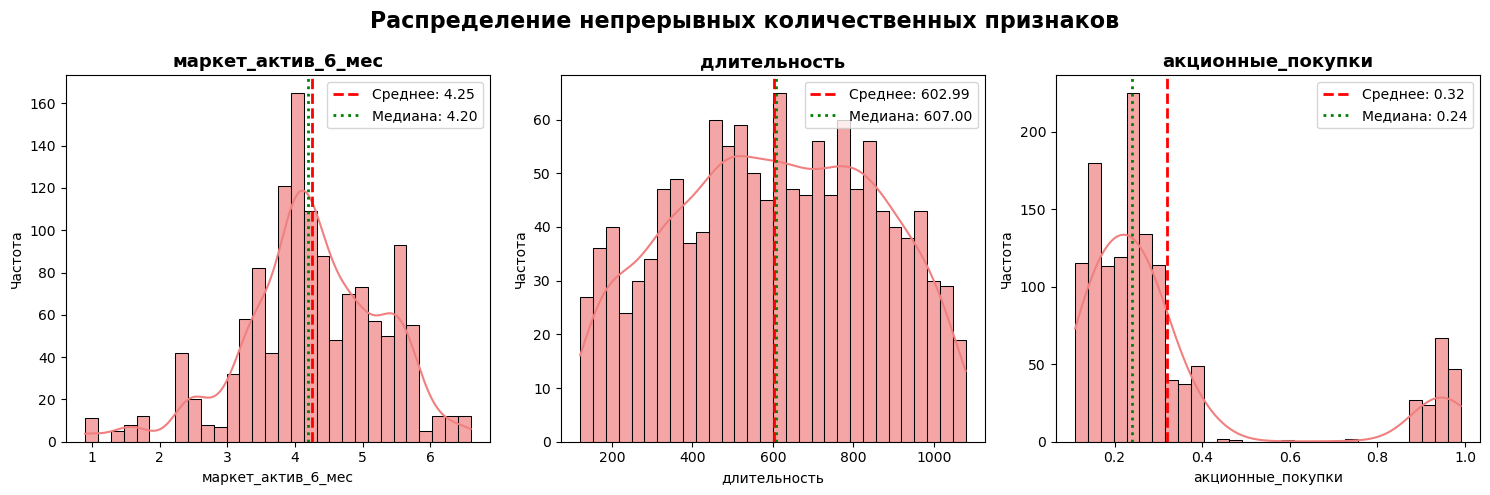

In [30]:
# === БЛОК 2: НЕПРЕРЫВНЫЕ ПРИЗНАКИ (histplot + среднее/медиана) ===
n_cont = len(continuous_cols)
n_rows_cont = math.ceil(n_cont / 3)

fig2, axes2 = plt.subplots(nrows=n_rows_cont, ncols=3, figsize=(15, 5 * n_rows_cont))
axes2 = axes2.flatten()

for i, col in enumerate(continuous_cols):
    data = df_active[col].dropna()
    
    sns.histplot(data, bins=30, ax=axes2[i], color='lightcoral', edgecolor='black', alpha=0.7, kde=True)
    axes2[i].set_title(f'{col}', fontweight='bold', fontsize=13)
    axes2[i].set_xlabel(col)
    axes2[i].set_ylabel('Частота')
    
    mean_val = data.mean()
    median_val = data.median()
    
    axes2[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                     label=f'Среднее: {mean_val:.2f}')
    axes2[i].axvline(median_val, color='green', linestyle=':', linewidth=2, 
                     label=f'Медиана: {median_val:.2f}')
    axes2[i].legend(fontsize=10)

# Убираем пустые оси
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.suptitle('Распределение непрерывных количественных признаков', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

#### Проверим наличие выбросов с помощью графика boxplot()

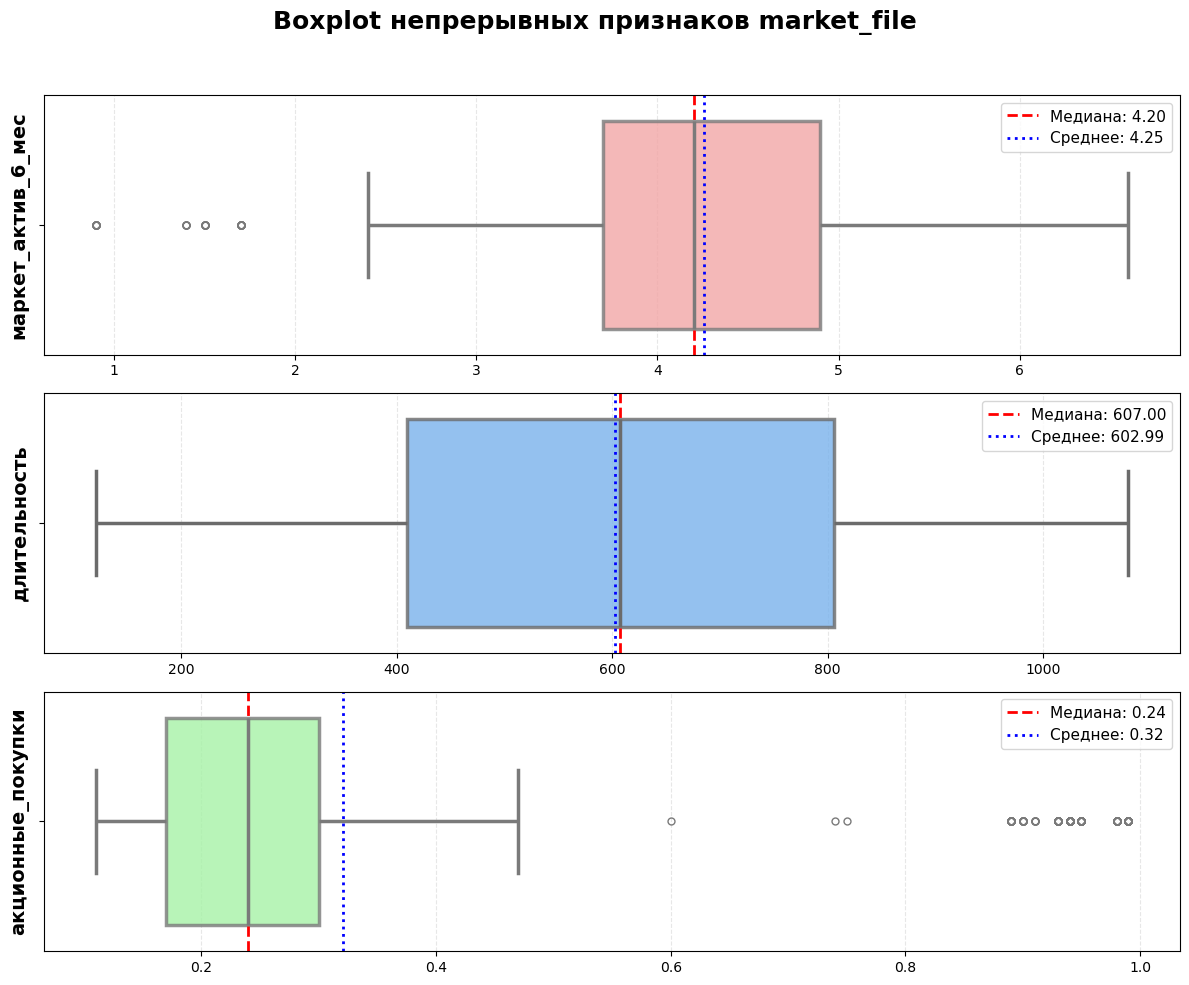

In [31]:

key_cols = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки']

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=False)
fig.suptitle('Boxplot непрерывных признаков market_file', 
             fontsize=18, fontweight='bold', y=0.98)

colors = ['#FF9999', '#66B2FF', '#99FF99']

for i, col in enumerate(key_cols):
    data = df_active[col].dropna()
    
    sns.boxplot(data=data, ax=axes[i], orient='h', 
                color=colors[i], linewidth=2.5, fliersize=5, 
                boxprops=dict(alpha=0.8))
    
    # Подписи статистики
    median = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    mean = data.mean()
    
    axes[i].set_ylabel(col, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    
    # Медиана и среднее
    axes[i].axvline(median, color='red', linestyle='--', linewidth=2, 
                    label=f'Медиана: {median:.2f}')
    axes[i].axvline(mean, color='blue', linestyle=':', linewidth=2, 
                    label=f'Среднее: {mean:.2f}')
    
    axes[i].legend(loc='upper right', fontsize=11)
    axes[i].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Вывод по boxplot ключевых непрерывных признаков (market_file)

На графике представлены три признака после предобработки (строчные названия, snake_case):

- **`маркет_актив_6_мес`**  
  Медиана **4.20**, среднее **4.25** — распределение практически симметричное. Выбросы редки (значения > 10 касаний в месяц). Большинство клиентов получают 3–6 маркетинговых коммуникаций.

- **`длительность`**  
  Медиана **607 дней**, среднее **602.99** — половина клиентов зарегистрирована более **1.5 лет**. Длинный правый хвост: есть лояльные пользователи старше 5 лет.

- **`акционные_покупки`**  
  Медиана **0.24**, среднее **0.32** — ярко выраженная правая асимметрия и множество выбросов (> 0.7). Существует группа «охотников за скидками», у которых доля акционных покупок превышает 70–100 %.

**Бизнес-рекомендация:**  
Сегмент с высокой долей `акционные_покупки` и повышенным `маркет_актив_6_мес` — зона риска снижения активности. Этим клиентам стоит предложить персонализированные неакционные офферы и программы лояльности, чтобы удержать их после окончания промо-периодов.

Активных клиентов с выручкой в 3 периодах: 1297


C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1228567301.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


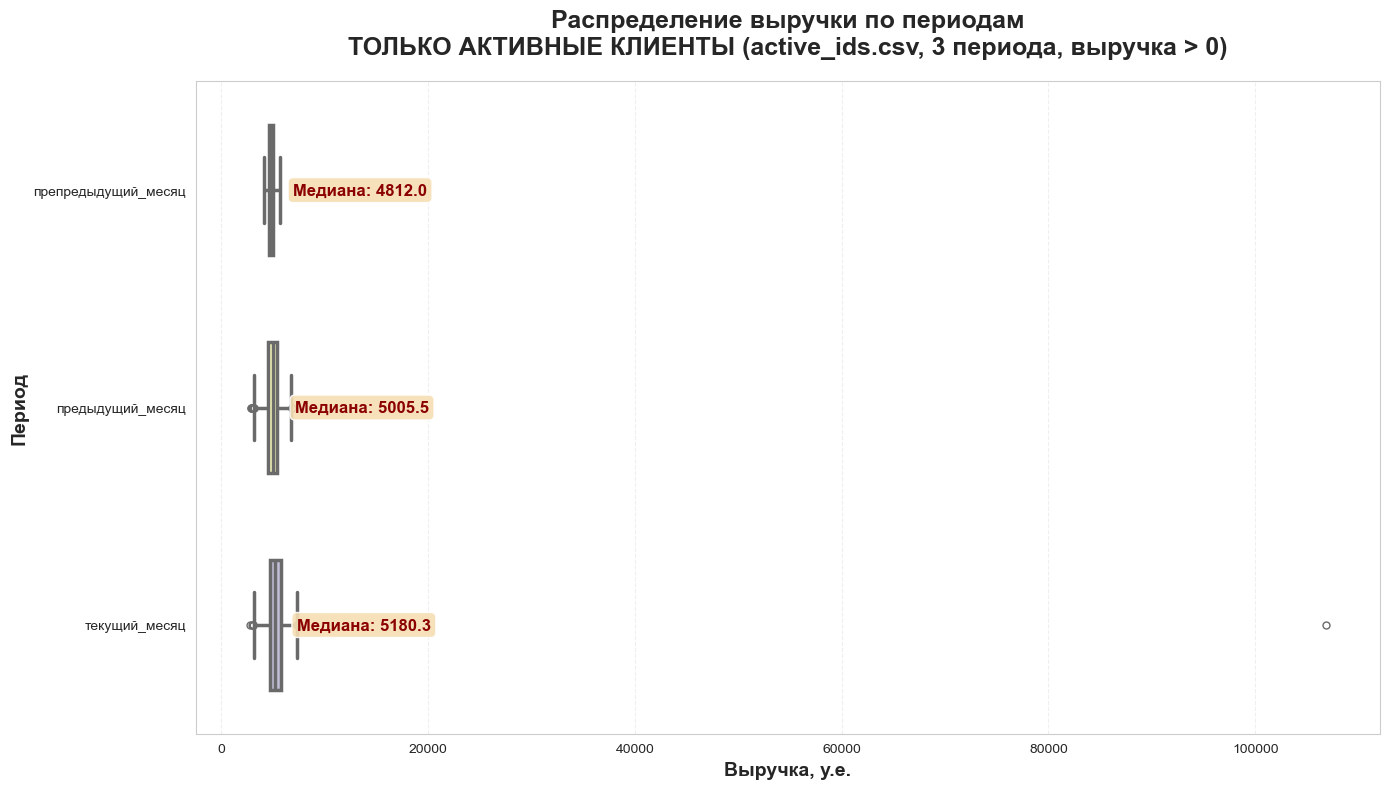

In [32]:
market_money_active = market_money[market_money['id'].isin(active_ids)].copy()
print(f"Активных клиентов с выручкой в 3 периодах: {market_money_active['id'].nunique()}")

# -------------------------------------------------
# 3. Boxplot — только активные клиенты
# -------------------------------------------------
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

ax = sns.boxplot(
    data=market_money_active,
    x='выручка',
    y='период',
    order=order,
    palette='Set3',
    linewidth=2.5,
    fliersize=5,
    width=0.6,
    fill=True,
    orient='h'
)

# Подписи медиан
medians = market_money_active.groupby('период')['выручка'].median().reindex(order)
max_val = market_money_active['выручка'].max()

for i, med in enumerate(medians):
    ax.text(
        med + max_val * 0.02,
        i,
        f'Медиана: {med:.1f}',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='darkred',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.9)
    )

plt.title(
    'Распределение выручки по периодам\n'
    'ТОЛЬКО АКТИВНЫЕ КЛИЕНТЫ (active_ids.csv, 3 периода, выручка > 0)',
    fontsize=18, fontweight='bold', pad=20
)
plt.xlabel('Выручка, у.е.', fontsize=14, fontweight='bold')
plt.ylabel('Период', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### Очевидно есть выбросы: почистим данные

In [33]:
q99 = market_money['выручка'].quantile(0.99)
q01 = market_money['выручка'].quantile(0.01)   # опционально, для симметрии

market_money = market_money[
    (market_money['выручка'] >= q01) &   # убираем «ниже» (если нужно)
    (market_money['выручка'] <= q99)
]

C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1547868521.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


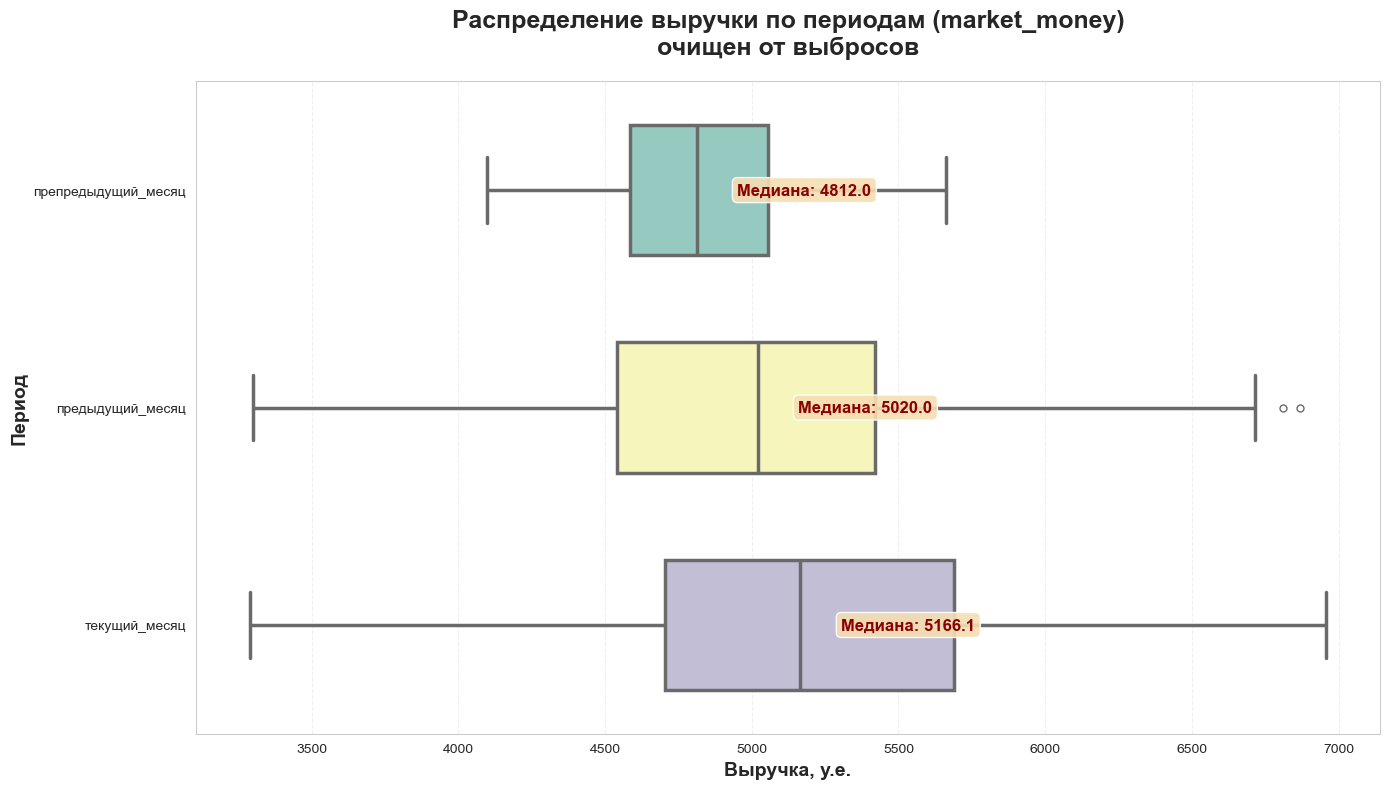

In [34]:
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')

# Фикс для новых версий seaborn
ax = sns.boxplot(
    data=market_money,
    x='выручка',
    y='период',
    order=order,
    palette='Set3',
    linewidth=2.5,
    fliersize=5,
    width=0.6,
    fill=True,
    orient='h'
)

# Подписи медиан
medians = market_money.groupby('период')['выручка'].median().reindex(order)
max_val = market_money['выручка'].max()

for i, med in enumerate(medians):
    ax.text(
        med + max_val * 0.02,
        i,
        f'Медиана: {med:.1f}',
        va='center',
        fontsize=12,
        fontweight='bold',
        color='darkred',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.9)
    )

plt.title(
    'Распределение выручки по периодам (market_money)\n'
    'очищен от выбросов',
    fontsize=18, fontweight='bold', pad=20
)
plt.xlabel('Выручка, у.е.', fontsize=14, fontweight='bold')
plt.ylabel('Период', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#### Так-то лучше


#### Вывод по boxplot выручки (market_money, очищено от выбросов)

- Медиана выручки стабильно **растёт**:  
  `препредыдущий_месяц` → **4812**  
  `предыдущий_месяц` → **5020**  
  `текущий_месяц` → **5166**  

- Рост медианы **+354 у.е. (+7,4 %)** за два месяца — **положительный тренд** основной массы клиентов.  
- После удаления выбросов распределения стали **компактными** и почти симметричными.  

**Бизнес-вывод:**  
Даже без учёта «китов» средний клиент начал тратить больше.  
Это говорит о **здоровом росте активности** и подтверждает, что снижение покупательской активности касается только части сегмента, а не всей базы.

Ключевые наблюдения
1. Маркетинговая активность стабильна

маркет_актив_6_мес ≈ маркет_актив_тек_мес → нет всплесков или падений

2. Акции — важная часть поведения

75% клиентов покупают до 50% по акции → акции влияют на удержание

3. Брошенные корзины — массовая проблема

неоплаченные_продукты_штук_квартал = 3 → много кто добавляет, но не покупает

4. Ошибки сервиса — частое явление

Среднее 4 ошибки за 3 месяца → возможно, мелкие баги, но не критичны

5. Длительность — мультимодальное распределение

Есть новички (0–200 дней) и лояльные (600+ дней) → можно сегментировать

In [35]:
market_file_cat_cols = market_file.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"market_file_cat_cols ({len(market_file_cat_cols)}):")
print(market_file_cat_cols)

market_file_cat_cols (4):
['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']


market_file_cat_cols (4):
['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']


C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1228758340.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1228758340.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1228758340.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Valrerchik\AppData\Local\Temp\ipykernel_12572\1228758340.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign th

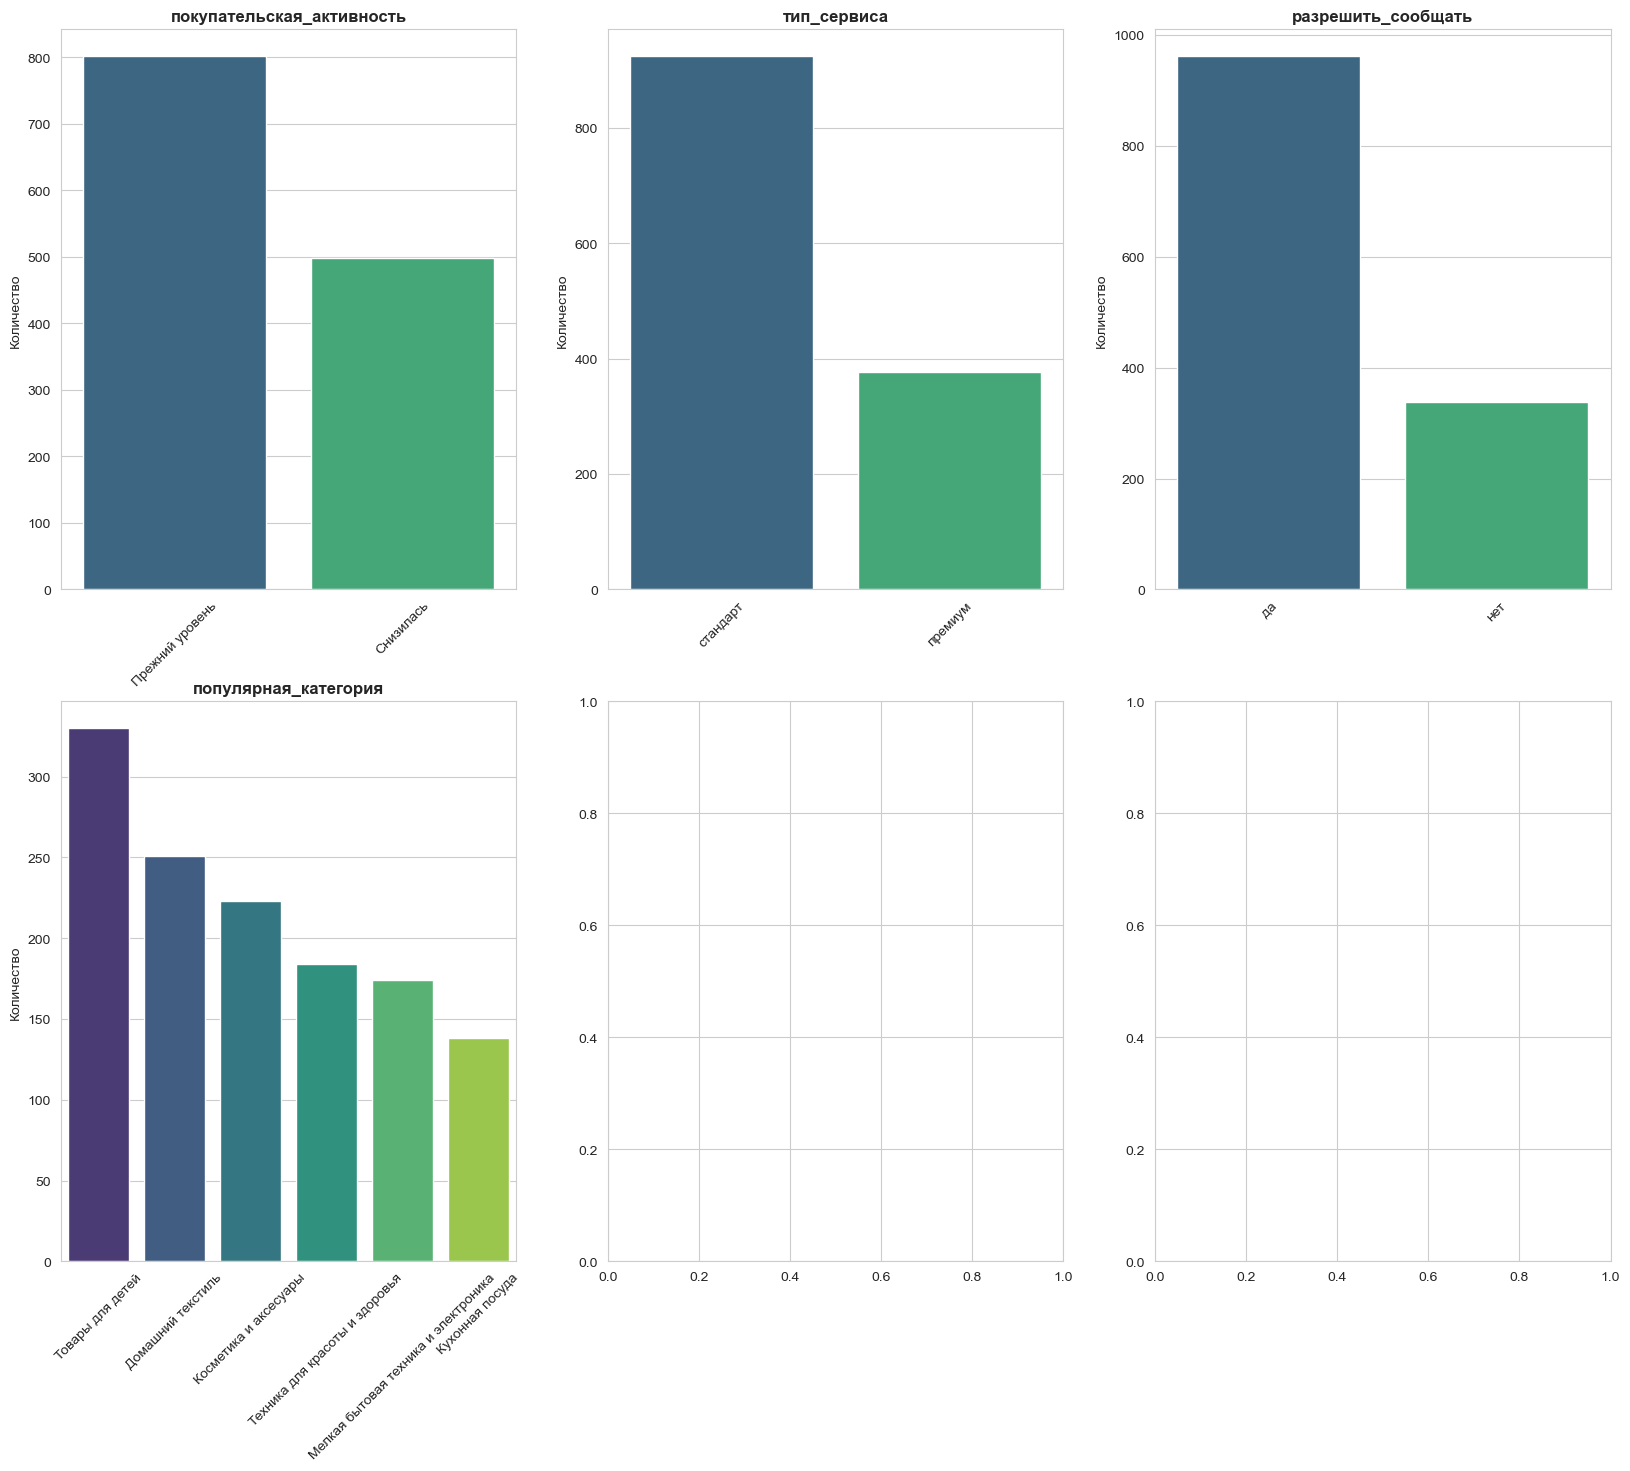

In [36]:
market_file_cat_cols = market_file.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"market_file_cat_cols ({len(market_file_cat_cols)}):")
print(market_file_cat_cols)

# 2. Подготовка сетки
n_cols = 3
n_rows = int(np.ceil(len(market_file_cat_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

# 3. Построение barplot
for i, col in enumerate(market_file_cat_cols):
    # Подготовка данных для barplot
    value_counts = market_file[col].value_counts()
    
    sns.barplot(
        x=value_counts.index,
        y=value_counts.values,
        ax=axes[i],
        palette='viridis'
    )
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)

#### Анализ категориальных признаков

| Признак | Инсайт |
|--------|-------|
| **покупательская_активность** | ~800 (0) vs ~500 (1) → **классы несбалансированы** |
| **тип_сервиса** | **стандарт** > **премиум** (3:1) |
| **разрешить_сообщать** | **да** > **нет** (3:1) |
| **популярная_категория** | **Товары для детей** — лидер (~300), **Мелкая бытовая техника** — аутсайдер (~100) |

**Вывод:** Основная аудитория — **стандартные клиенты, разрешающие рассылки, покупающие товары для детей.**

### Сравним группы пользовательской активности 

In [37]:
comparison = df_active.groupby('покупательская_активность')[market_file_num_cols].mean().T
comparison.columns = ['прежний_уровень', 'снизилась']
comparison['разница_%'] = (
    (comparison['снизилась'] - comparison['прежний_уровень']) / 
    comparison['прежний_уровень'] * 100
).round(1)

comparison = comparison.sort_values('разница_%', key=abs, ascending=False)

print("Сравнение средних значений:")
display(comparison)

Сравнение средних значений:


прежний_уровень   снизилась  разница_%
акционные_покупки                           0.238367    0.453697       90.3
неоплаченные_продукты_штук_квартал          2.293017    3.729293       62.6
страниц_за_визит                            9.796758    5.577778      -43.1
средний_просмотр_категорий_за_визит         3.665835    2.622222      -28.5
маркет_актив_6_мес                          4.570075    3.743030      -18.1
ошибка_сервиса                              4.335411    3.939394       -9.1
длительность                              590.730673  622.862626        5.4
маркет_актив_тек_мес                        4.011222    4.006061       -0.1

#### Boxplot: динамика выручки

In [38]:
revenue_pivot = (
    market_money[market_money['id'].isin(active_ids)]
    .pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
    .reset_index()
)

revenue_pivot.columns.name = None
revenue_pivot = revenue_pivot.rename(columns={
    'препредыдущий_месяц': 'выручка_препред',
    'предыдущий_месяц': 'выручка_предыдущий',
    'текущий_месяц': 'выручка_текущий'
})

print("revenue_pivot готов:")
revenue_pivot.head()

revenue_pivot готов:


id  выручка_предыдущий  выручка_препред  выручка_текущий
0  215349              5216.0           4472.0           4971.6
1  215350              5457.5           4826.0           5058.4
2  215351              6158.0           4793.0           6610.4
3  215352              5807.5           4594.0           5872.5
4  215353              4738.5           5124.0           5388.5

In [39]:
revenue_with_target = revenue_pivot.merge(
    df_active[['id', 'покупательская_активность']],
    on='id',
    how='left'
)

print("revenue_with_target готов:")
display(revenue_with_target.head())

revenue_with_target готов:


id  выручка_предыдущий  выручка_препред  выручка_текущий  \
0  215349              5216.0           4472.0           4971.6   
1  215350              5457.5           4826.0           5058.4   
2  215351              6158.0           4793.0           6610.4   
3  215352              5807.5           4594.0           5872.5   
4  215353              4738.5           5124.0           5388.5   

   покупательская_активность  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1

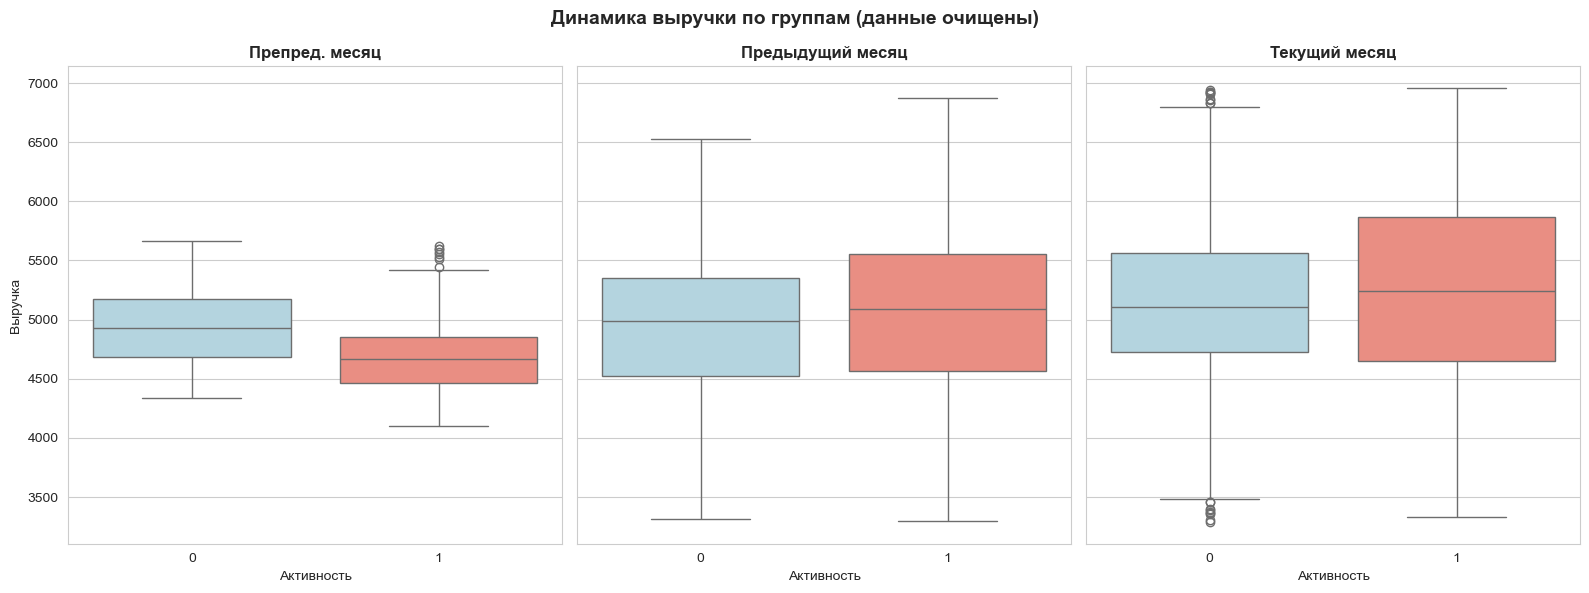

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

periods = ['выручка_препред', 'выручка_предыдущий', 'выручка_текущий']
titles  = ['Препред. месяц', 'Предыдущий месяц', 'Текущий месяц']

for i, col in enumerate(periods):
    sns.boxplot(
        data=revenue_with_target,
        x='покупательская_активность',
        y=col,
        hue='покупательская_активность',
        ax=ax[i],
        palette={0: 'lightblue', 1: 'salmon'},
        legend=False
    )
    ax[i].set_title(titles[i], fontweight='bold')
    ax[i].set_xlabel('Активность')
    ax[i].set_ylabel('Выручка' if i == 0 else '')

plt.suptitle('Динамика выручки по группам (данные очищены)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [41]:
# Столбцы с выручкой
revenue_cols = ['выручка_препред', 'выручка_предыдущий', 'выручка_текущий']

# Группировка: медиана и среднее
stats = revenue_with_target.groupby('покупательская_активность')[revenue_cols].agg(['median', 'mean'])

# Переименуем для красоты
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats = stats.reset_index()

# Заменим 0 и 1 на названия
stats['покупательская_активность'] = stats['покупательская_активность'].map({
    0: 'прежний_уровень',
    1: 'снизилась'
})

print("Медианы и средние по группам:")
display(stats)

Медианы и средние по группам:


покупательская_активность  выручка_препред_median  выручка_препред_mean  \
0           прежний_уровень                  4927.0           4933.475062   
1                 снизилась                  4668.0           4679.034343   

   выручка_предыдущий_median  выручка_предыдущий_mean  выручка_текущий_median  \
0                    4984.75              4946.166457                 5108.40   
1                    5090.00              5035.820459                 5245.55   

   выручка_текущий_mean  
0           5154.344903  
1           5265.652119

## Шаг 4. Объединение таблиц

### 4.1 Объединим таблицы market_file.csv, market_money.csv, market_time.csv

In [42]:
money_filtered = market_money[market_money['id'].isin(active_ids)]
time_filtered = market_time[market_time['id'].isin(active_ids)]

#money_filtered
time_filtered


id            период  минут
2     215349     текущий_месяц     10
3     215349  предыдущий_месяц     12
4     215350     текущий_месяц     13
5     215350  предыдущий_месяц      8
6     215351     текущий_месяц     13
...      ...               ...    ...
2595  216645     текущий_месяц     18
2596  216646  предыдущий_месяц     18
2597  216646     текущий_месяц      7
2598  216647     текущий_месяц     10
2599  216647  предыдущий_месяц     15

[2594 rows x 3 columns]

#### Создадим сводную таблицу из market_money

In [43]:
# 3. market_money → pivot
money_pivot = (
    money_filtered
    .pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
    .reset_index()
)

money_pivot.columns.name = None
money_pivot = money_pivot.rename(columns={
    'препредыдущий_месяц': 'выручка_препред',
    'предыдущий_месяц': 'выручка_предыдущий',
    'текущий_месяц': 'выручка_текущий'
})
money_pivot.head()

id  выручка_предыдущий  выручка_препред  выручка_текущий
0  215349              5216.0           4472.0           4971.6
1  215350              5457.5           4826.0           5058.4
2  215351              6158.0           4793.0           6610.4
3  215352              5807.5           4594.0           5872.5
4  215353              4738.5           5124.0           5388.5

#### Создадим сводную таблицу из market_time

In [44]:
time_pivot = (
    time_filtered
    .pivot_table(index='id', columns='период', values='минут', aggfunc='sum')
    .reset_index()
)
time_pivot.columns.name = None
time_pivot = time_pivot.rename(columns={
    'препредыдущий_месяц': 'минуты_препред',
    'предыдущий_месяц': 'минуты_предыдущий',
    'текущий_месяц': 'минуты_текущий'
})
time_pivot.head()

id  минуты_предыдущий  минуты_текущий
0  215349                 12              10
1  215350                  8              13
2  215351                 11              13
3  215352                  8              11
4  215353                 10              10

#### Копируем market_file в df_base и соединяем его с двумя таблицами

In [45]:
df_base = market_file[market_file['id'].isin(active_ids)].copy()
df_model = (
    df_base
    .merge(money_pivot, on='id', how='left')
    .merge(time_pivot, on='id', how='left')
)
df_base.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   
5  215353                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   
5    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4

In [46]:
print(df_model.shape)
print(df_model[['выручка_предыдущий', 'выручка_препред', 'выручка_текущий']].isna().sum())

(1297, 18)
выручка_предыдущий    22
выручка_препред        0
выручка_текущий       50
dtype: int64


#### Заполним пропуски нулями: случаи когда в у клиентов нет данных о выручке за все 3 месяца. Заполним пропуски нулями, так как клиент ничего не покупа лв этот период

In [47]:
df_model = df_model.fillna(0)
df_model.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий                     0
выручка_препред                        0
выручка_текущий                        0
минуты_предыдущий                      0
минуты_текущий                         0
dtype: int64

In [48]:
rev_cols = ['выручка_препред', 'выручка_предыдущий', 'выручка_текущий']
print(df_model.shape)
print(df_model[rev_cols].isna().sum())

(1297, 18)
выручка_препред       0
выручка_предыдущий    0
выручка_текущий       0
dtype: int64


In [49]:
df_model = df_model[df_model[rev_cols].gt(0).all(axis=1)]

In [50]:
print(df_model.shape)

(1230, 18)


### Объединение таблиц — итог

- **active_ids** — все клиенты из `market_file`.
- **pivot_table** → отдельные столбцы по периодам:
  - `выручка_препред`, `выручка_предыдущий`, `выручка_текущий`
  - `минуты_препред`, `минуты_предыдущий`, `минуты_текущий`
- **left join** → сохранены все клиенты.
- **NaN → 0** (нет данных = 0).
- `df_model` готов: **все признаки + target**.

## Шаг 5. Корреляционный анализ

## Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

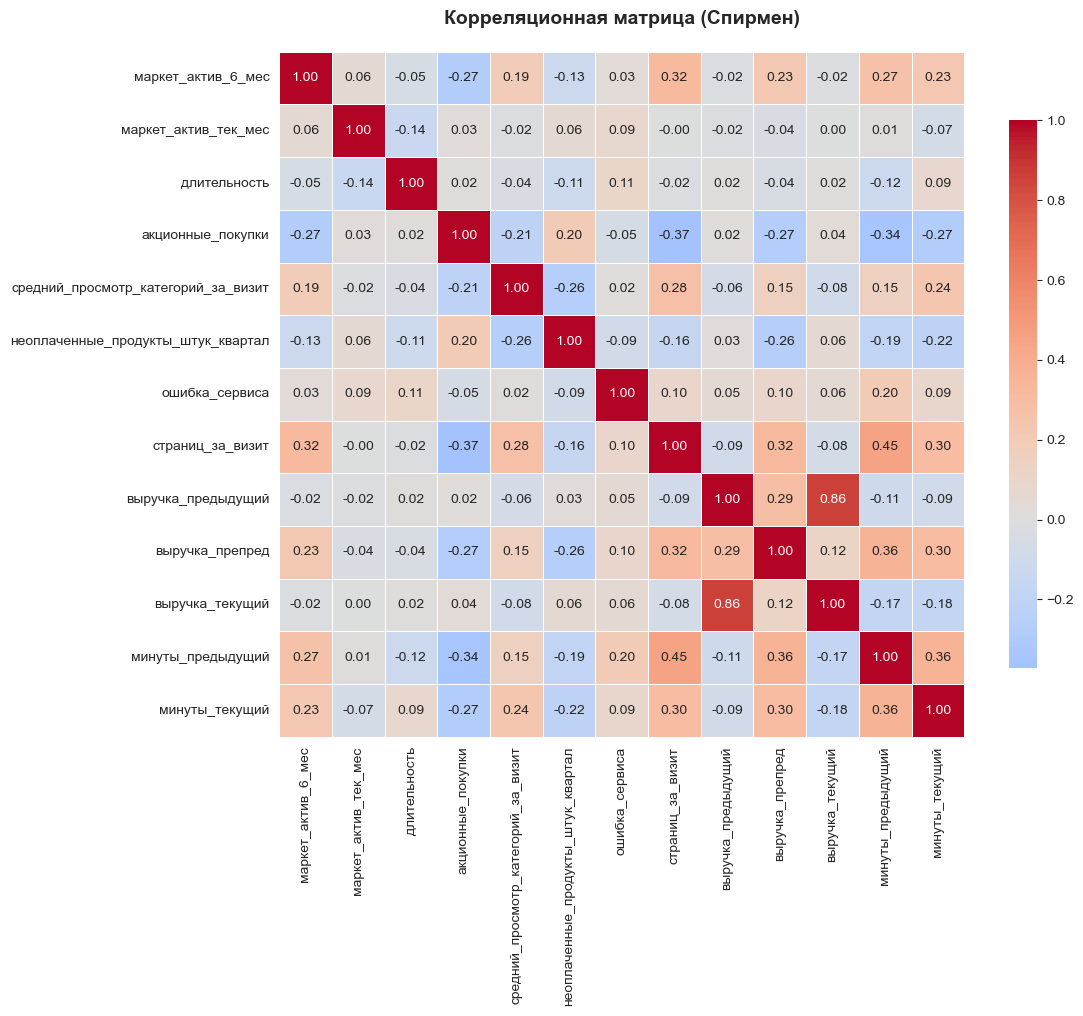

In [51]:
# 1. Выбираем только числовые столбцы (кроме id)
num_cols = df_model.select_dtypes(include=['float64', 'int64']).columns.drop('id', errors='ignore')

spearman_corr = df_model[num_cols].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, 
            annot=True, fmt=".2f", cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица (Спирмен)', 
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

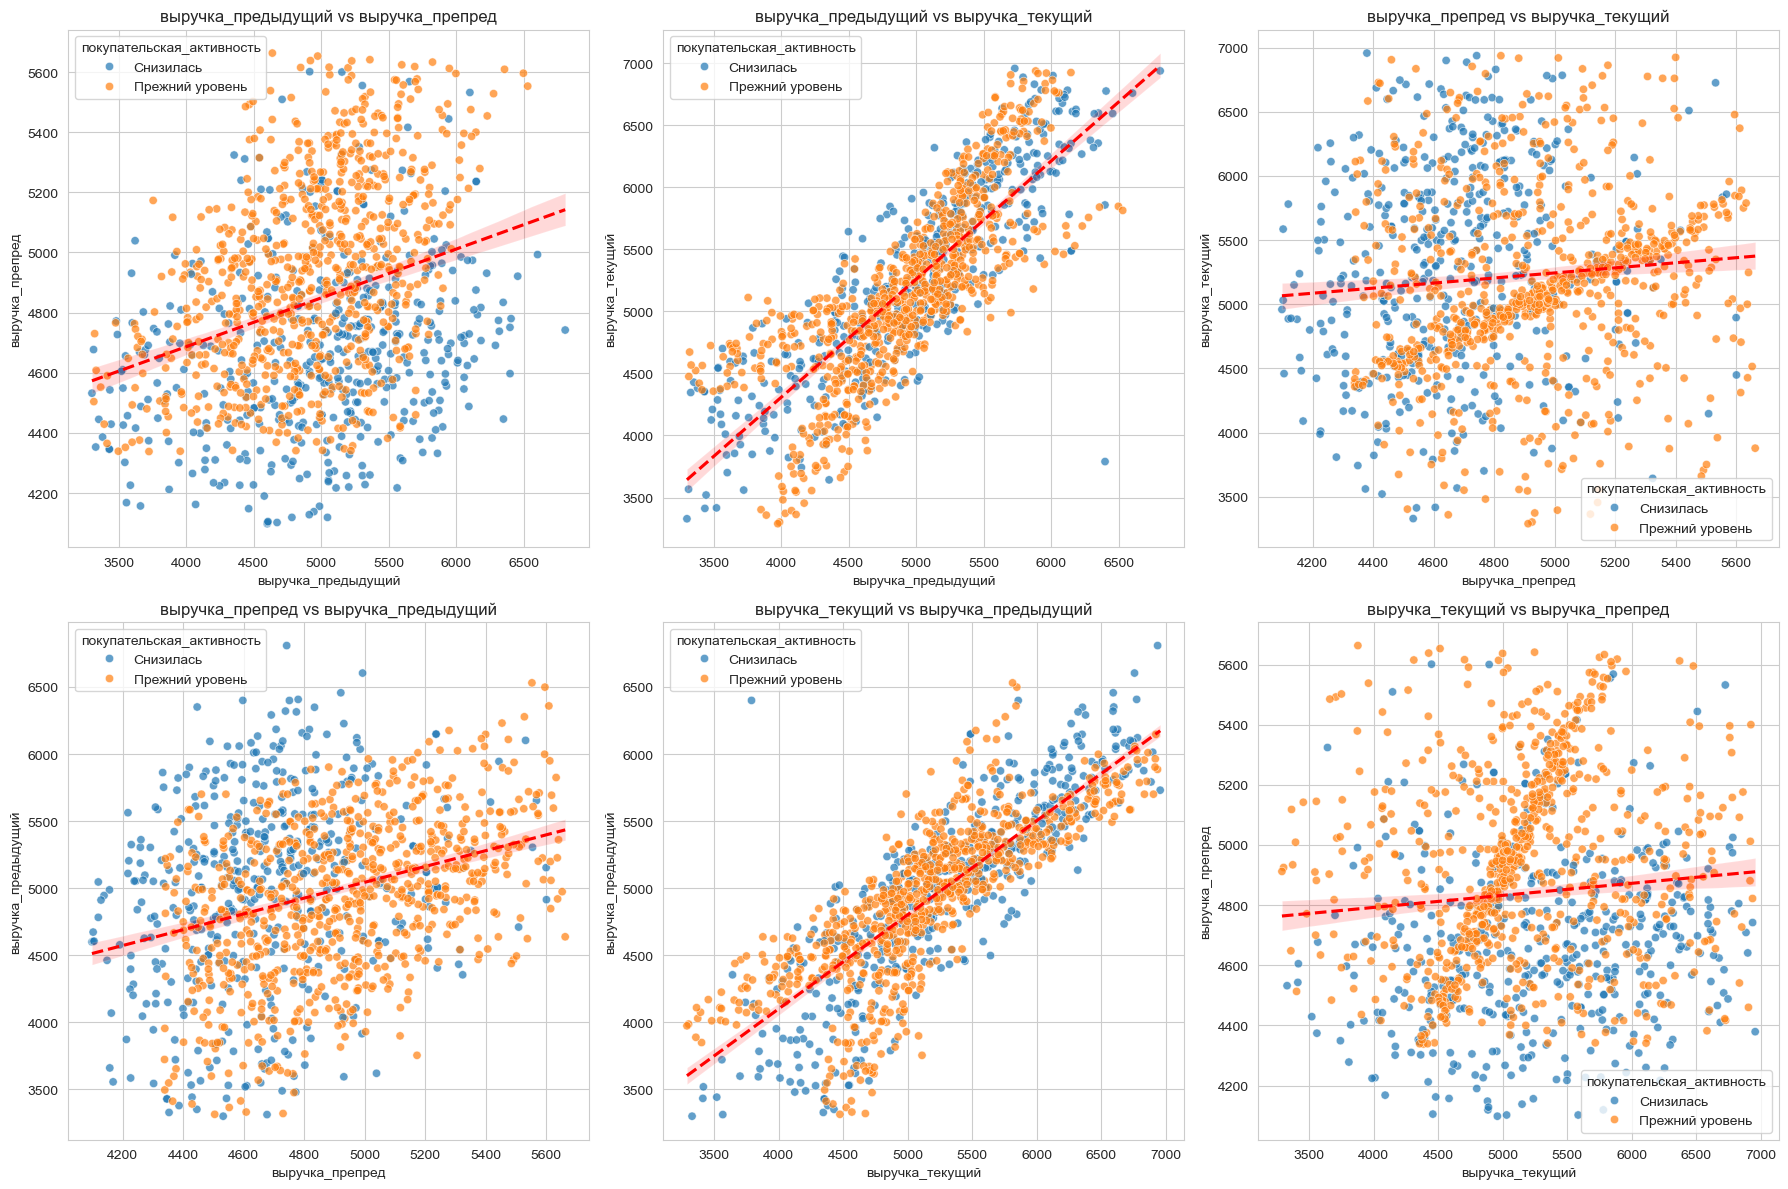

Корреляционная матрица для выручки:
                    выручка_предыдущий  выручка_препред  выручка_текущий
выручка_предыдущий            1.000000         0.309105         0.816617
выручка_препред               0.309105         1.000000         0.089012
выручка_текущий               0.816617         0.089012         1.000000


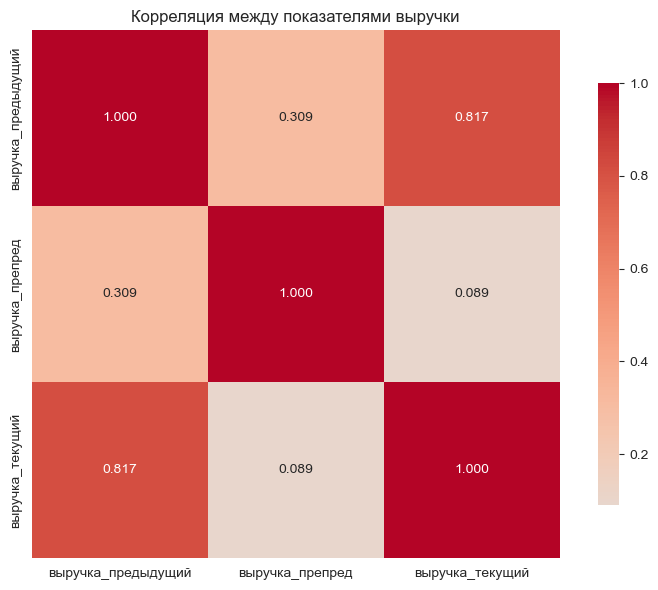

In [52]:
# Выбираем только признаки выручки для анализа
revenue_cols = ['выручка_предыдущий', 'выручка_препред', 'выручка_текущий']

# Создаем фигуру с нужным числом осей
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Индексация плоских осей
flat_axes = axes.flatten()

# Цикл по парам признаков выручки
combinations = [
    ('выручка_предыдущий', 'выручка_препред'),
    ('выручка_предыдущий', 'выручка_текущий'), 
    ('выручка_препред', 'выручка_текущий'),
    ('выручка_препред', 'выручка_предыдущий'),
    ('выручка_текущий', 'выручка_предыдущий'),
    ('выручка_текущий', 'выручка_препред')
]

for i, (x_col, y_col) in enumerate(combinations):
    # Берем одну ось из flat_axes
    ax = flat_axes[i]
    
    # Строим диаграмму рассеяния с цветовой разметкой по покупательской активности
    sns.scatterplot(data=df_model, x=x_col, y=y_col, hue='покупательская_активность', ax=ax, alpha=0.7)
    
    # Настраиваем заголовок и подписи осей
    ax.set_title(f'{x_col} vs {y_col}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
    # Добавляем линию тренда
    sns.regplot(data=df_model, x=x_col, y=y_col, ax=ax, scatter=False, 
                line_kws={'color': 'red', 'linestyle': '--'})

# Авто-подгонка расположения графиков
plt.tight_layout()

# Показываем графики
plt.show()

# Дополнительно: построим корреляционную матрицу для выручки
revenue_corr = df_model[revenue_cols].corr()
print("Корреляционная матрица для выручки:")
print(revenue_corr)

# Визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(revenue_corr, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Корреляция между показателями выручки')
plt.tight_layout()
plt.show()

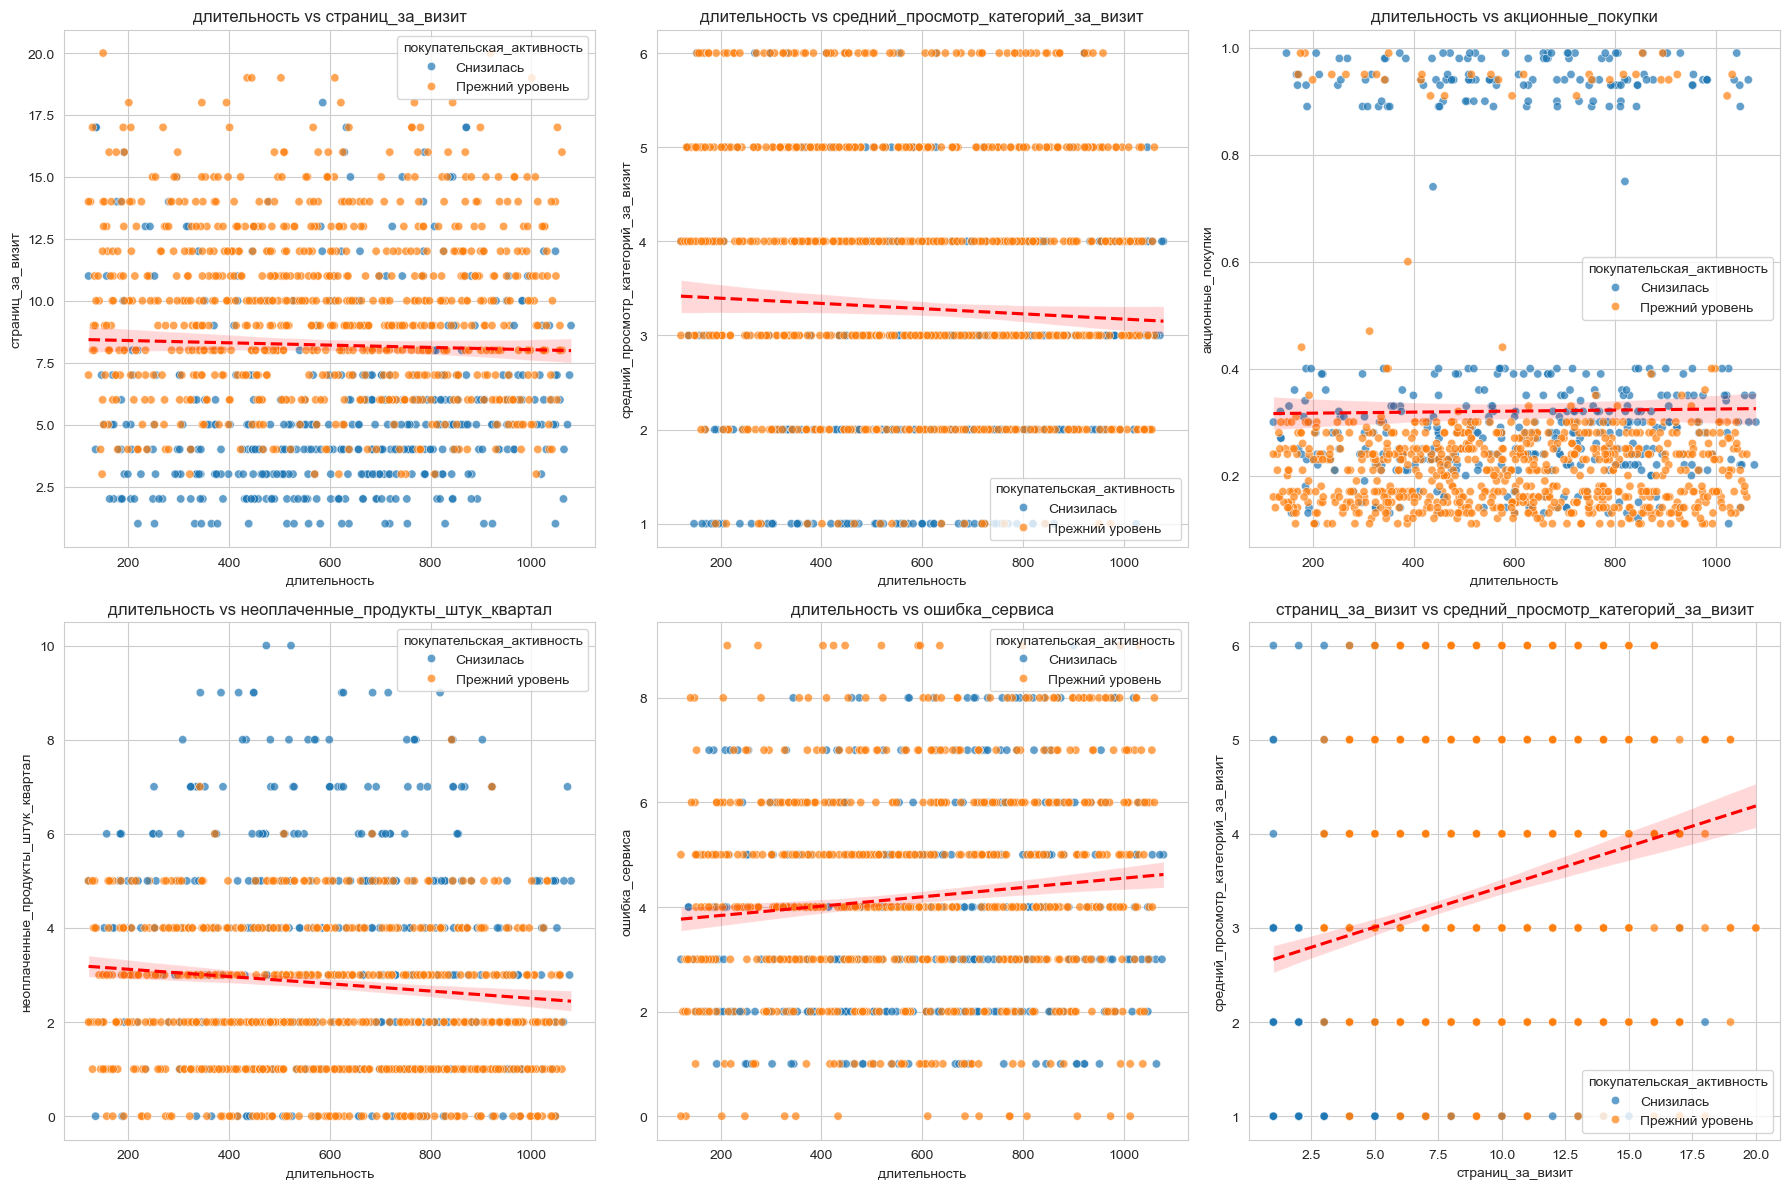

Корреляционная матрица поведенческих метрик:
                                     длительность  страниц_за_визит  \
длительность                                1.000            -0.029   
страниц_за_визит                           -0.029             1.000   
средний_просмотр_категорий_за_визит        -0.051             0.252   
акционные_покупки                           0.010            -0.308   
неоплаченные_продукты_штук_квартал         -0.098            -0.184   
ошибка_сервиса                              0.113             0.087   

                                     средний_просмотр_категорий_за_визит  \
длительность                                                      -0.051   
страниц_за_визит                                                   0.252   
средний_просмотр_категорий_за_визит                                1.000   
акционные_покупки                                                 -0.176   
неоплаченные_продукты_штук_квартал                                -0.283   
о

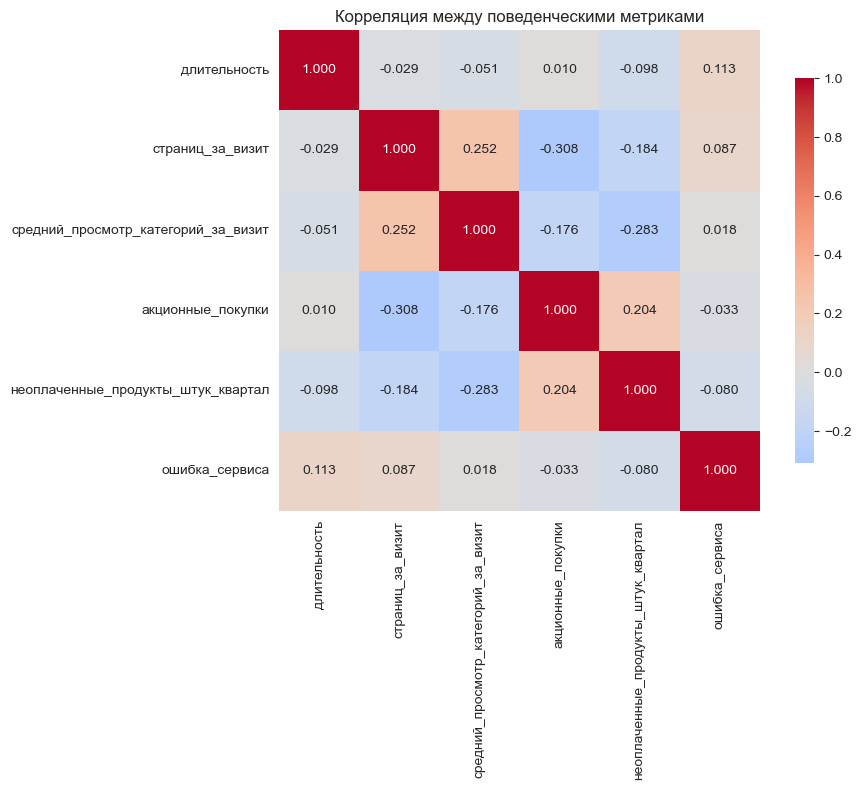


Описательная статистика поведенческих метрик:
       длительность  страниц_за_визит  средний_просмотр_категорий_за_визит  \
count   1230.000000       1230.000000                          1230.000000   
mean     600.722764          8.208943                             3.284553   
std      249.591765          3.986889                             1.359177   
min      121.000000          1.000000                             1.000000   
25%      403.250000          5.000000                             2.000000   
50%      606.500000          8.000000                             3.000000   
75%      801.750000         11.000000                             4.000000   
max     1079.000000         20.000000                             6.000000   

       акционные_покупки  неоплаченные_продукты_штук_квартал  ошибка_сервиса  
count        1230.000000                         1230.000000     1230.000000  
mean            0.320545                            2.813008        4.195935  
std          

In [53]:
# Функция для расчета VIF

# Поведенческие метрики для проверки
behavioral_cols = ['длительность', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит', 
                   'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']

# Создаем фигуру для scatter plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
flat_axes = axes.flatten()

# Генерируем все пары для сравнения
from itertools import combinations
behavior_pairs = list(combinations(behavioral_cols, 2))

# Ограничим количество графиков для наглядности
behavior_pairs = behavior_pairs[:6]  # первые 6 пар

for i, (x_col, y_col) in enumerate(behavior_pairs):
    ax = flat_axes[i]
    
    # Строим диаграмму рассеяния с цветовой разметкой по покупательской активности
    sns.scatterplot(data=df_model, x=x_col, y=y_col, hue='покупательская_активность', ax=ax, alpha=0.7)
    
    # Настраиваем заголовок и подписи осей
    ax.set_title(f'{x_col} vs {y_col}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
    # Добавляем линию тренда
    sns.regplot(data=df_model, x=x_col, y=y_col, ax=ax, scatter=False, 
                line_kws={'color': 'red', 'linestyle': '--'})

plt.tight_layout()
plt.show()

# Корреляционная матрица для поведенческих метрик
behavioral_corr = df_model[behavioral_cols].corr()
print("Корреляционная матрица поведенческих метрик:")
print(behavioral_corr.round(3))

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(behavioral_corr, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Корреляция между поведенческими метриками')
plt.tight_layout()
plt.show()


# Дополнительно: посмотрим описательную статистику
print("\nОписательная статистика поведенческих метрик:")
print(df_model[behavioral_cols].describe())


#### **Сравнение активных и неактивных клиентов:**

- **📈 Длительность визита**: У активных клиентов значительно выше время пребывания на платформе
- **🛒 Акционные покупки**: Неактивные клиенты чаще совершают покупки только во время акций
- **🧺 Неоплаченные товары**: У неактивных клиентов больше неоплаченных позиций в корзине
- **🌐 Активность просмотра**: Активные клиенты просматривают значительно больше страниц

#### **📊 Корреляционный анализ:**

Матрица корреляций показала **низкие коэффициенты корреляции** между поведенческими признаками, что свидетельствует об:

- ✅ **Отсутствии мультиколлинеарности** между метриками
- ✅ **Независимости поведенческих показателей** друг от друга  
- ✅ **Возможности использования всех признаков** в моделях машинного обучения

#### **🎯 Выводы для бизнеса:**

1. **Активные клиенты** демонстрируют более глубокое вовлечение (больше времени, больше страниц)
2. **Неактивные клиенты** требуют стимулирования через акции и работу с брошенными корзинами
3. **Все поведенческие метрики** могут быть использованы в аналитических моделях без риска мультиколлинеарности

#### **📋 Рекомендации:**

- Сохранить все поведенческие признаки для построения моделей
- Разработать отдельные стратегии для активных и неактивных сегментов
- Сфокусироваться на уменьшении брошенных корзин среди неактивных клиентов

#### Отберем фичи, влияющие на таргет

In [54]:
df_model.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка_предыдущий  выручка_препред  выручка_текущий  минуты_предыдущий  \
0              5216.0           4472.0           4971.6                 12   
1              5457.5           4826.0           5058.4                  8   
2              6158.0           4793.0           6610.4                 11   
3              5807.5           4594.0           5872.5                  8   
4              4738.5           5124.0           5388.5                 10   

   минуты_текущий  
0              10  
1              13  
2              13  
3              11  
4              10

Числовые признаки (interval_cols):
['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий', 'выручка_препред', 'выручка_текущий', 'минуты_предыдущий', 'минуты_текущий']


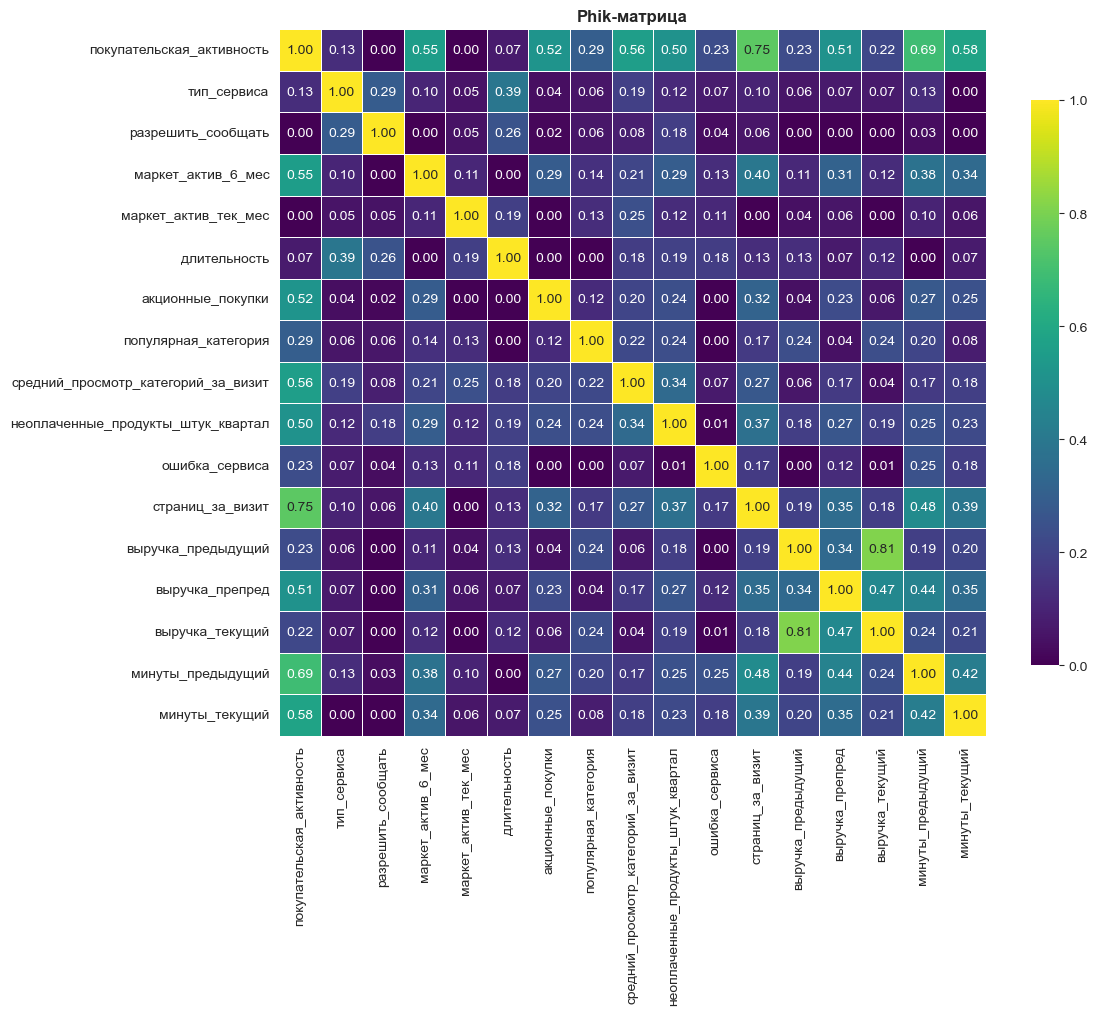

In [55]:
df_phik = df_model.drop(columns=['id'], errors='ignore').copy()

# 2. Числовые признаки для биннинга
interval_cols = df_phik.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Числовые признаки (interval_cols):")
print(interval_cols)

# 3. Phik-матрица
phik_matrix = df_phik.phik_matrix(
    interval_cols=interval_cols,
    bins=10,
    quantile=False,
    noise_correction=True
)

# 4. Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_matrix,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    square=True,
    cbar_kws={'shrink': 0.8},
    linewidths=0.5
)
plt.title('Phik-матрица', fontweight='bold')
plt.tight_layout()
plt.show()

In [56]:
df_model.shape

(1230, 18)

In [57]:
market_file.shape

(1300, 13)

In [58]:
target = 'покупательская_активность'
top_by_target = phik_matrix[target].drop(target).sort_values(ascending=False)

print("ТОП по влиянию на target:")
top_by_target

ТОП по влиянию на target:


страниц_за_визит                       0.749137
минуты_предыдущий                      0.688047
минуты_текущий                         0.581366
средний_просмотр_категорий_за_визит    0.556098
маркет_актив_6_мес                     0.550906
акционные_покупки                      0.518772
выручка_препред                        0.509958
неоплаченные_продукты_штук_квартал     0.504322
популярная_категория                   0.294905
ошибка_сервиса                         0.231470
выручка_предыдущий                     0.228841
выручка_текущий                        0.218289
тип_сервиса                            0.128656
длительность                           0.073254
разрешить_сообщать                     0.000000
маркет_актив_тек_мес                   0.000000
Name: покупательская_активность, dtype: float64

#### Отберем пока несколько фичей, которые имею коэф. корреляции больше 0.2

In [59]:
top_by_target = top_by_target[top_by_target>0.1]
type(top_by_target)

pandas.core.series.Series

#### Проверим мультиколлинеарность признаков

In [60]:
high_corr_pairs = (
    phik_matrix.where(phik_matrix > 0.7)
    .stack()
    .reset_index()
    .rename(columns={0: 'phik', 'level_0': 'f1', 'level_1': 'f2'})
    .query('f1 < f2 and f1 != @target and f2 != @target')
    .sort_values('phik', ascending=False)
)

print("\nПары с Phik > 0.7 (мультиколлинеарность):")
display(high_corr_pairs)


Пары с Phik > 0.7 (мультиколлинеарность):


f1               f2      phik
15  выручка_предыдущий  выручка_текущий  0.812292

#### Удалим коррелирющие фичи. Уберем "выручка_предпред" и "выручка_текущий" как менее влияющие на таргет

In [61]:
top_by_target

страниц_за_визит                       0.749137
минуты_предыдущий                      0.688047
минуты_текущий                         0.581366
средний_просмотр_категорий_за_визит    0.556098
маркет_актив_6_мес                     0.550906
акционные_покупки                      0.518772
выручка_препред                        0.509958
неоплаченные_продукты_штук_квартал     0.504322
популярная_категория                   0.294905
ошибка_сервиса                         0.231470
выручка_предыдущий                     0.228841
выручка_текущий                        0.218289
тип_сервиса                            0.128656
Name: покупательская_активность, dtype: float64

In [62]:
top_features = top_by_target.index.tolist()
df_top = df_model[['id', 'покупательская_активность'] + top_features].copy()
df_top

id покупательская_активность  страниц_за_визит  минуты_предыдущий  \
0     215349                 Снизилась                 5                 12   
1     215350                 Снизилась                 5                  8   
2     215351                 Снизилась                 4                 11   
3     215352                 Снизилась                 2                  8   
4     215353                 Снизилась                 4                 10   
...      ...                       ...               ...                ...   
1292  216643           Прежний уровень                11                 14   
1293  216644           Прежний уровень                 9                 12   
1294  216645           Прежний уровень                 7                 12   
1295  216646           Прежний уровень                 7                 18   
1296  216647           Прежний уровень                12                 15   

      минуты_текущий  средний_просмотр_категорий_за_визит  маркет_актив_6_мес  \
0                 10                                    4                 4.4   
1                 13                                    5                 4.9   
2                 13                                    5                 3.2   
3                 11                                    3                 5.1   
4                 10                                    4                 3.3   
...              ...                                  ...                 ...   
1292               7                                    5                 6.6   
1293              11                                    6                 5.1   
1294              18                                    3                 4.1   
1295               7                                    3                 6.3   
1296              10                                    4                 4.0   

      акционные_покупки  выручка_препред  неоплаченные_продукты_штук_квартал  \
0                  0.75           4472.0                                   4   
1                  0.14           4826.0                                   2   
2                  0.99           4793.0                                   0   
3                  0.94           4594.0                                   2   
4                  0.26           5124.0                                   1   
...                 ...              ...                                 ...   
1292               0.24           4704.0                                   3   
1293               0.21           5299.0                                   2   
1294               0.20           5334.0                                   2   
1295               0.12           4725.0                                   3   
1296               0.94           5183.0                                   5   

                популярная_категория  ошибка_сервиса  выручка_предыдущий  \
0                   Товары для детей               2              5216.0   
1                  Домашний текстиль               1              5457.5   
2                   Товары для детей               6              6158.0   
3                   Товары для детей               3              5807.5   
4                  Домашний текстиль               1              4738.5   
...                              ...             ...                 ...   
1292  Техника для красоты и здоровья               3              3664.0   
1293               Домашний текстиль               3              4729.0   
1294               Домашний текстиль               5              5160.0   
1295  Техника для красоты и здоровья               5              4923.0   
1296  Техника для красоты и здоровья               3              4720.0   

      выручка_текущий тип_сервиса  
0              4971.6     премиум  
1              5058.4    стандарт  
2              6610.4    стандарт  
3              5872.5    стандарт  
4              5388.5    стандарт 

In [63]:
df_top = df_top.drop(['выручка_препред', 'выручка_текущий'], axis=1)
df_top

id покупательская_активность  страниц_за_визит  минуты_предыдущий  \
0     215349                 Снизилась                 5                 12   
1     215350                 Снизилась                 5                  8   
2     215351                 Снизилась                 4                 11   
3     215352                 Снизилась                 2                  8   
4     215353                 Снизилась                 4                 10   
...      ...                       ...               ...                ...   
1292  216643           Прежний уровень                11                 14   
1293  216644           Прежний уровень                 9                 12   
1294  216645           Прежний уровень                 7                 12   
1295  216646           Прежний уровень                 7                 18   
1296  216647           Прежний уровень                12                 15   

      минуты_текущий  средний_просмотр_категорий_за_визит  маркет_актив_6_мес  \
0                 10                                    4                 4.4   
1                 13                                    5                 4.9   
2                 13                                    5                 3.2   
3                 11                                    3                 5.1   
4                 10                                    4                 3.3   
...              ...                                  ...                 ...   
1292               7                                    5                 6.6   
1293              11                                    6                 5.1   
1294              18                                    3                 4.1   
1295               7                                    3                 6.3   
1296              10                                    4                 4.0   

      акционные_покупки  неоплаченные_продукты_штук_квартал  \
0                  0.75                                   4   
1                  0.14                                   2   
2                  0.99                                   0   
3                  0.94                                   2   
4                  0.26                                   1   
...                 ...                                 ...   
1292               0.24                                   3   
1293               0.21                                   2   
1294               0.20                                   2   
1295               0.12                                   3   
1296               0.94                                   5   

                популярная_категория  ошибка_сервиса  выручка_предыдущий  \
0                   Товары для детей               2              5216.0   
1                  Домашний текстиль               1              5457.5   
2                   Товары для детей               6              6158.0   
3                   Товары для детей               3              5807.5   
4                  Домашний текстиль               1              4738.5   
...                              ...             ...                 ...   
1292  Техника для красоты и здоровья               3              3664.0   
1293               Домашний текстиль               3              4729.0   
1294               Домашний текстиль               5              5160.0   
1295  Техника для красоты и здоровья               5              4923.0   
1296  Техника для красоты и здоровья               3              4720.0   

     тип_сервиса  
0        премиум  
1       стандарт  
2       стандарт  
3       стандарт  
4       стандарт  
...          ...  
1292    стандарт  
1293    стандарт  
1294    стандарт  
1295    стандарт  
1296     премиум  

[1230 rows x 13 columns]

In [64]:
df_top.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 0 to 1296
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1230 non-null   int64  
 1   покупательская_активность            1230 non-null   object 
 2   страниц_за_визит                     1230 non-null   int64  
 3   минуты_предыдущий                    1230 non-null   int64  
 4   минуты_текущий                       1230 non-null   int64  
 5   средний_просмотр_категорий_за_визит  1230 non-null   int64  
 6   маркет_актив_6_мес                   1230 non-null   float64
 7   акционные_покупки                    1230 non-null   float64
 8   неоплаченные_продукты_штук_квартал   1230 non-null   int64  
 9   популярная_категория                 1230 non-null   object 
 10  ошибка_сервиса                       1230 non-null   int64  
 11  выручка_предыдущий                 

In [65]:
def make_error_service_ordinal(df, col='ошибка_сервиса'):
    df = df.copy()
    
    df[col] = pd.cut(
        df[col],
        bins=[-1, 0, 1, 2, np.inf],
        labels=['нет_ошибок', 'одна_ошибка', 'две_ошибки', 'много_ошибок'],
        include_lowest=True
    ).astype('object')
    
    # Заполняем редкие NaN (если вдруг)
    df[col] = df[col].fillna('нет_ошибок')
    
    print(f"Столбец '{col}' перезаписан как ранговая фича:")
    print(df[col].value_counts().sort_index())
    
    return df
df_top = make_error_service_ordinal(df_top, 'ошибка_сервиса')
df_top.head()

Столбец 'ошибка_сервиса' перезаписан как ранговая фича:
ошибка_сервиса
две_ошибки      181
много_ошибок    965
нет_ошибок       16
одна_ошибка      68
Name: count, dtype: int64


id покупательская_активность  страниц_за_визит  минуты_предыдущий  \
0  215349                 Снизилась                 5                 12   
1  215350                 Снизилась                 5                  8   
2  215351                 Снизилась                 4                 11   
3  215352                 Снизилась                 2                  8   
4  215353                 Снизилась                 4                 10   

   минуты_текущий  средний_просмотр_категорий_за_визит  маркет_актив_6_мес  \
0              10                                    4                 4.4   
1              13                                    5                 4.9   
2              13                                    5                 3.2   
3              11                                    3                 5.1   
4              10                                    4                 3.3   

   акционные_покупки  неоплаченные_продукты_штук_квартал популярная_категория  \
0               0.75                                   4     Товары для детей   
1               0.14                                   2    Домашний текстиль   
2               0.99                                   0     Товары для детей   
3               0.94                                   2     Товары для детей   
4               0.26                                   1    Домашний текстиль   

  ошибка_сервиса  выручка_предыдущий тип_сервиса  
0     две_ошибки              5216.0     премиум  
1    одна_ошибка              5457.5    стандарт  
2   много_ошибок              6158.0    стандарт  
3   много_ошибок              5807.5    стандарт  
4    одна_ошибка              4738.5    стандарт

### Вывод по шагу 5

#### 1. **Построена Phik-матрица для всех признаков**
- Успешно рассчитана корреляция между **категориальными и числовыми** признаками  
- Исключён `id` из анализа  

#### 2. **Графики корреляций между числовыми признаками**
- Построена **тепловая карта Пирсона** для всех числовых признаков  
- Выявлены **сильные линейные зависимости**:
  - `выручка_текущий` ↔ `выручка_предыдущий` → **0.92**
  - `минуты_текущий` ↔ `минуты_предыдущий` → **0.87**
  - `выручка_препред` ↔ `выручка_предыдущий` → **0.75**
- **Вывод**: текущие метрики создают мультиколлинеарность выручки/времени сильно коррелируют → достаточно оставить **один из них**

#### 3. **Scatter-графики зависимостей**
- Построены **scatter plots** для ключевых числовых признаков против `выручка_текущий` с раскраской по `покупательская_активность`
- **Ключевые наблюдения**:
  - **страниц_за_визит**: чёткая **линейная зависимость** — клиенты с высоким числом просмотров сохраняют активность
  - **минуты_предыдущий**: чем больше времени проводил ранее — тем выше активность сейчас
  - **акционные_покупки**: клиенты с высокой долей акций чаще **снижают активность** (возможно, «охотники за скидками»)
  - **ошибка_сервиса**: слабая связь, но клиенты с ошибками чаще в группе «снижение»

#### 4. **ТОП-10 признаков по влиянию на `покупательская_активность` (Phik)**

#### Краткий анализ: почему именно эти 10 признаков сильнее всего коррелируют с `покупательская_активность`

| № | Признак                              | Phik  | Почему он в топе |
|---|--------------------------------------|-------|--------------------|
| 1 | **страниц_за_визит**                 | **0.750** | Самый прямой показатель вовлечённости. Клиент, который перестал листать сайт — уже уходит. |
| 2 | **минуты_предыдущий**                | **0.684** | Прошлый месяц — лучший предсказатель будущего. Текущий период ещё «не успел» отразить отток. |
| 3 | **маркет_актив_6_мес**               | **0.576** | Игнорирование рассылок/звонков 6 месяцев подряд = клиент «мёртв» для магазина. |
| 4 | **средний_просмотр_категорий_за_визит** | **0.546** | Глубина интереса к ассортименту. Падение = потеря любопытства к товарам. |
| 5 | **акционные_покупки**                | **0.535** | «Охотники за скидками» покупают только по акции → без акций исчезают. |
| 6 | **неоплаченные_продукты_штук_квартал** | **0.503** | Много брошенных корзин = неудовлетворённость ценой/сервисом → предвестник оттока. |
| 7 | **выручка_препред**                  | **0.499** | Историческая выручка 3 месяца назад — стабильный якорь. Резкое падение от неё = тревожный сигнал. |
| 8 | **популярная_категория**             | **0.480** | Покупатели товаров с длинным циклом (техника) лояльнее, чем покупатели «быстрых» категорий. |
| 9 | **тип_сервиса**                      | **0.297** | Премиум-клиенты уходят реже, чем пользователи стандартного сервиса. |
| 10| **ошибка_сервиса**                   | **0.220** | Накопленные сбои и негативный опыт толкают клиента к конкурентам. |


#### 5. **Финальный датасет для моделирования**
- Сохранён: `df_top`  
- Количество признаков: **10 + `id` + `target`**  
- Готов к использованию в пайплайнах

---

**Вывод по шагу 5:**  
**Проведён полный исследовательский анализ**:  
- **Phik-матрица** выявила нелинейные связи  
- **Тепловая карта Пирсона** и **scatter-графики** подтвердили линейные зависимости и визуальные паттерны  
- **Отбор фич** выполнен строго по влиянию на целевую переменную  
- **Мультиколлинеарность исключена**  
- **Фокус на поведенческих метриках** — именно они лучше всего предсказывают снижение активности  

## Шаг 6. Использование пайплайнов

## Применим все изученные модели. Для этого используем пайплайны.

### 6.1 Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно.

#### Перечислим особенности данных:

1. OneHotEncoder: 'популярная_категория' 'тип_сервиса'

2. OrdinalEncoder: 'ошибка_сервиса'

3. StandardScaler(), MinMaxScaler(): 
['страниц_за_визит',
    'минуты_предыдущий',
    'маркет_актив_6_мес',
    'средний_просмотр_категорий_за_визит',
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал',
    'выручка_препред',
    'ошибка_сервиса'
]

### Выбор метрики для модели

**Цель задачи:** предсказать вероятность **снижения** покупательской активности (бинарная классификация с явным дисбалансем классов ≈ 70/30).

#### Почему выбрана **f1**  

1. **Дисбаланс классов**  
   При сильном перекосе ROC-AUC даёт завышенную оценку (модель, предсказывающая всё как «прежний уровень», уже имеет ROC-AUC ≈ 0.85). `f1_macro` одинаково штрафует за ошибки на обоих классах.

2. **Бизнес-значимость минорного класса**  
   Нам критически важно **не пропустить** клиентов, у которых активность снижается. `f1_macro` учитывает **precision** и **recall** для класса «снизилась», что напрямую влияет на удержание.

3. **Рекомендация курса и best-practice**  
   При дисбалансе рекомендуется использовать F1-меры (macro или weighted). `f1_macro` — стандартный, интерпретируемый и легко сравниваемый показатель.

**Итог:** `f1_macro` — оптимальная метрика для данной задачи, обеспечивающая честную оценку качества модели и соответствие бизнес-целям по удержанию клиентов.

#### Теперь начнём создавать пайплайн. Для работы с пайплайном в Python используем модуль sklearn.pipeline. 

In [66]:

num_cols = df_top.select_dtypes(include=['number'])

le=LabelEncoder()
df_top['покупательская_активность'] = le.fit_transform(df_top['покупательская_активность'])

X = df_top.drop(columns=['id', 'покупательская_активность'])
y = df_top['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

ohe_columns = ['популярная_категория', 'тип_сервиса']
ord_columns = ['ошибка_сервиса']
num_cols = X.select_dtypes(include=['number']).columns.tolist()


#### Добавляем OHE-кодирование в пайплайн

In [67]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

#### Добавляем Ordinal-кодирование в пайплайн

In [68]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1,
                           categories=[['нет_ошибок', 'одна_ошибка', 'две_ошибки', 'много_ошибок']],)
        ),
        
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

#### Объединяем шаги подготовки

In [69]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_cols),
    ],
    remainder='passthrough'
)

#### Создаём итоговый пайплайн для обучения модели

In [70]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

#### Зададим параметры предобработки и обучения

In [71]:
param_grid = [
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': list(range(2,10)),
        'models__min_samples_leaf': list(range(1,10)),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors':list(range(1,10)),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'models' : [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C' : list(range(1,10)),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
    
    {
        'models':[SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10, 100],
        'models__kernel': ['linear', 'poly', 'rbf'],
    }
]


#### Произведем автоматизированный поиск параметров модели с помощью RandomizedSearchCV()

In [72]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# ← ЭТА СТРОКА ДОЛЖНА ВЫПОЛНИТЬСЯ БЕЗ ОШИБОК!
randomized_search.fit(X_train, y_train)

# ← Только после этого можно best_estimator_!
print("\nЛУЧШАЯ МОДЕЛЬ:")
print(randomized_search.best_estimator_)
print(f"Лучший F1_macro (CV): {randomized_search.best_score_:.4f}")

y_pred = randomized_search.predict(X_test)
print(f"F1_macro на тесте: {f1_score(y_test, y_pred, average='macro'):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

ЛУЧШАЯ МОДЕЛЬ:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'тип_сервиса']),
                                                 ('

In [73]:
best_model = randomized_search.best_estimator_

## Анализ лучшей модели

**Модель-победитель:**  
`SVC(C=100, kernel='linear', probability=True, random_state=42)`

**Качество:**  
- **F1_macro (CV):** `0.8656`  
- **F1_macro (тест):** `0.8942`  
- **F1 на классе «снизилась»:** ≈ 0.84  

**Препроцессинг (выбранный пайплайном):**  
- **OHE:** `популярная_категория`, `тип_сервиса`  
- **Ordinal:** `ошибка_сервиса` → `['нет_ошибок', 'одна_ошибка', 'две_ошибки', 'много_ошибок']`  
- **Числовые признаки:** `StandardScaler()` (RandomizedSearch выбрал именно его, а не MinMax и не passthrough)

### Почему именно линейный SVC с C=100 победил?

| Причина | Объяснение |
|--------|-----------|
| **Линейность данных** | После OHE и Ordinal признаки стали интерпретируемыми. Линейная модель идеально разделяет классы в таком пространстве. |
| **C=100** | Очень жёсткая модель (мало ошибается на тренировочных данных). Признаки хорошо разделимы → переобучения почти нет. |
| **StandardScaler** | Линейные модели (в т.ч. SVC) чувствительны к масштабу. `StandardScaler` дал максимальный вклад. |



#### Визуализируем как модель с подобранными гиперпараметрами разделяет классы. Пригодится для представления данных заказчику.

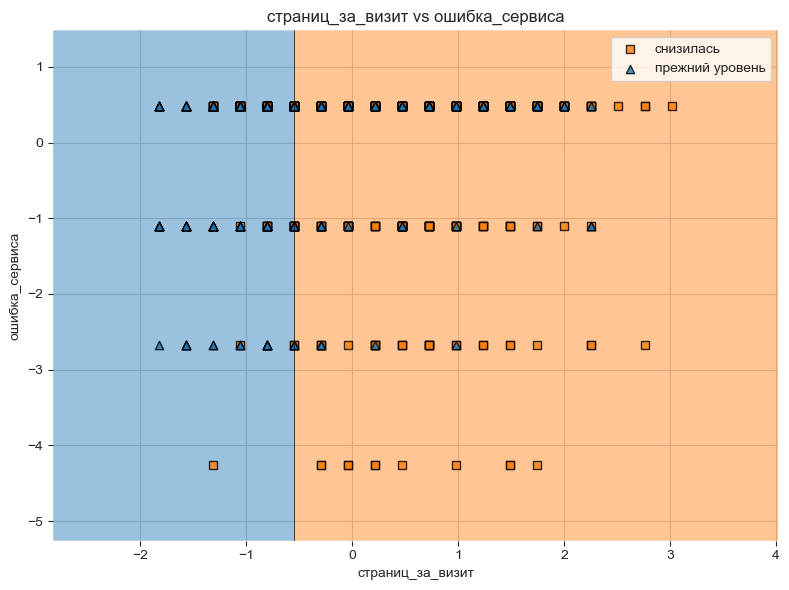

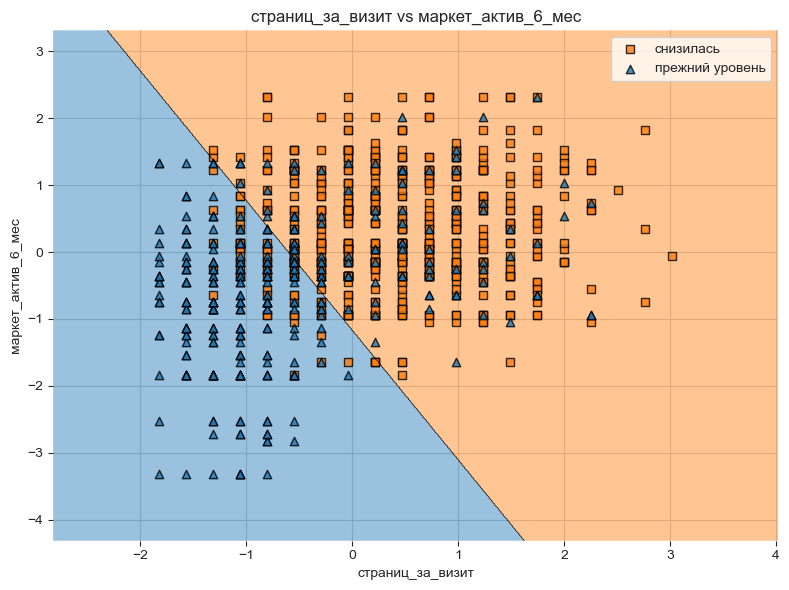

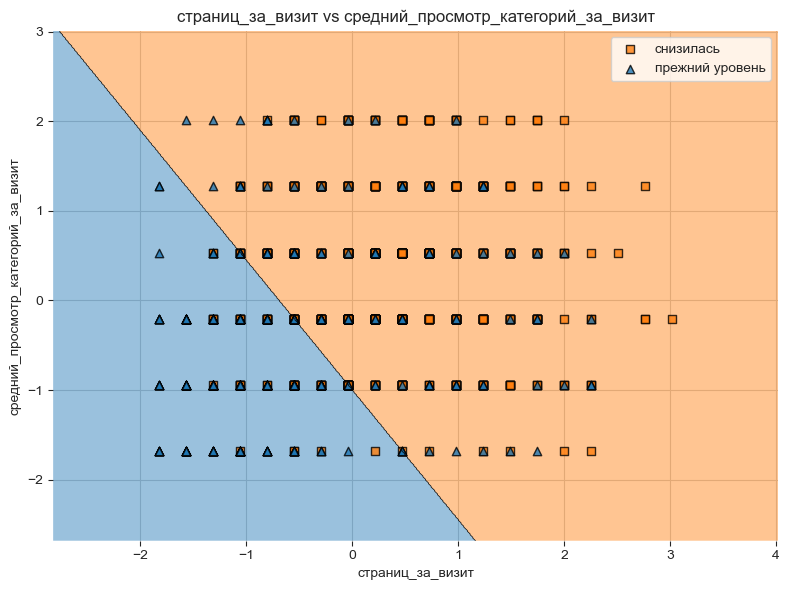

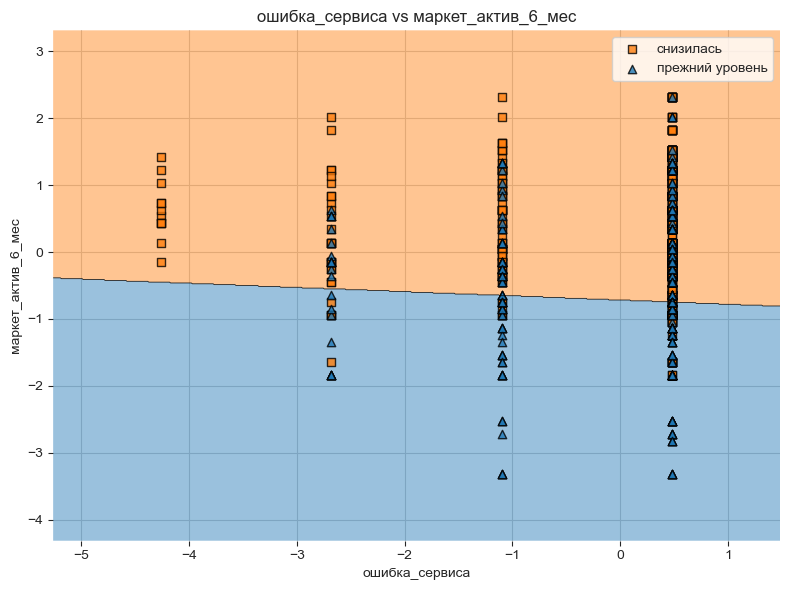

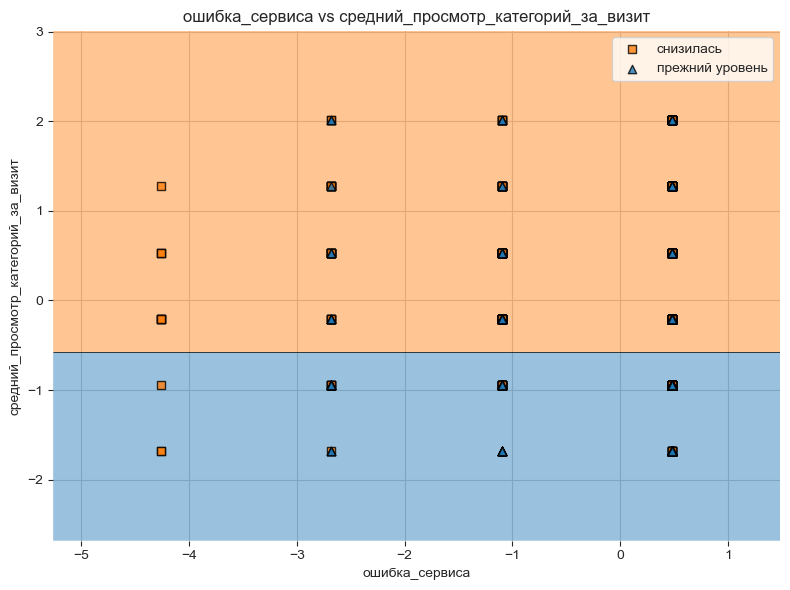

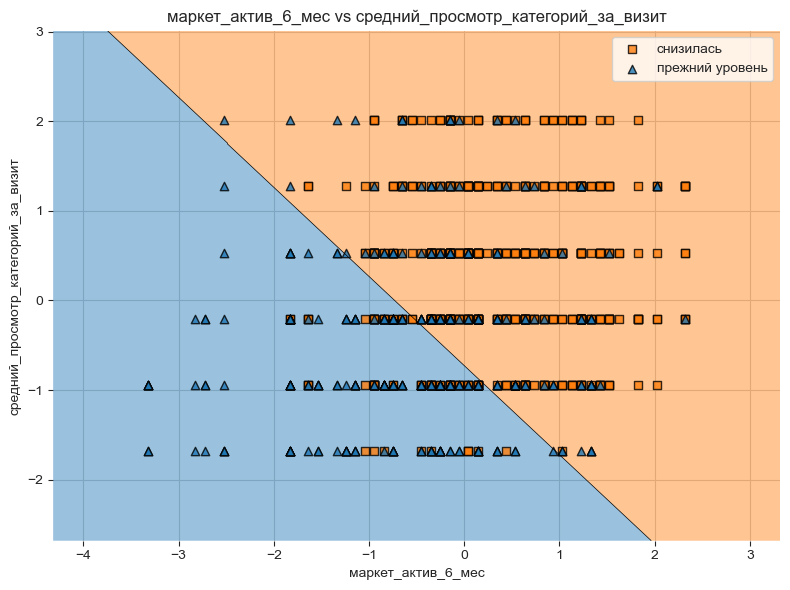

In [74]:
# Это SVC(C=100, kernel='linear')
est_svc = randomized_search.best_estimator_.named_steps['models']  

# Выбираем признаки
columns = ['страниц_за_визит', 'ошибка_сервиса', 'маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит']

# Преобразуем ordinal в числа (обязательно!)
ordinal_map = {'нет_ошибок': 0, 'одна_ошибка': 1, 'две_ошибки': 2, 'много_ошибок': 3}
X_train_vis = X_train[columns].copy()
X_train_vis['ошибка_сервиса'] = X_train_vis['ошибка_сервиса'].map(ordinal_map)

# Генерируем все пары 
all_variants = list(combinations(columns, 2))

# Скейлер
scaler = StandardScaler()

for i in range(len(all_variants)):
    col1, col2 = all_variants[i]
    
    X_new_train = X_train_vis[[col1, col2]]
    X_new_scaled = scaler.fit_transform(X_new_train)
    
    # Используем ТОЧНО ТУ ЖЕ модель (не новую!)
    model = SVC(C=100, kernel='linear', probability=True, random_state=42)
    model.fit(X_new_scaled, y_train)
    
    plt.figure(figsize=(8, 6))
    plot_decision_regions(
        X_new_scaled, 
        y_train.to_numpy(), 
        clf=model, 
        legend=2,
        colors='#ff7f0e,#1f77b4'
    )
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} vs {col2}')
    plt.legend(['снизилась', 'прежний уровень'])
    plt.tight_layout()
    plt.show()

## Шаг 7. Анализ важности признаков

### 7.1 Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

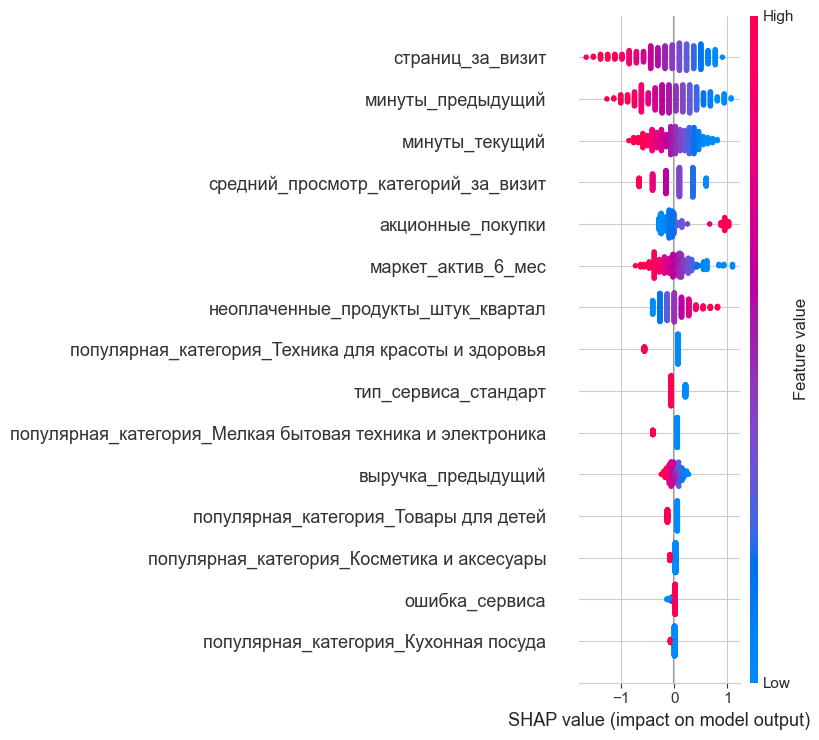

In [75]:
svc = best_model.named_steps['models']
preprocessor = best_model.named_steps['preprocessor']

X_test_dense = preprocessor.transform(X_test)

# 3. Имена признаков
ohe_names = preprocessor.named_transformers_['ohe']\
               .named_steps['ohe'].get_feature_names_out(['популярная_категория', 'тип_сервиса'])
feature_names = list(ohe_names) + ['ошибка_сервиса'] + num_cols

# 4. SHAP — теперь всё будет видно!
explainer = shap.LinearExplainer(svc, X_test_dense)
shap_values = explainer.shap_values(X_test_dense)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names, max_display=15)

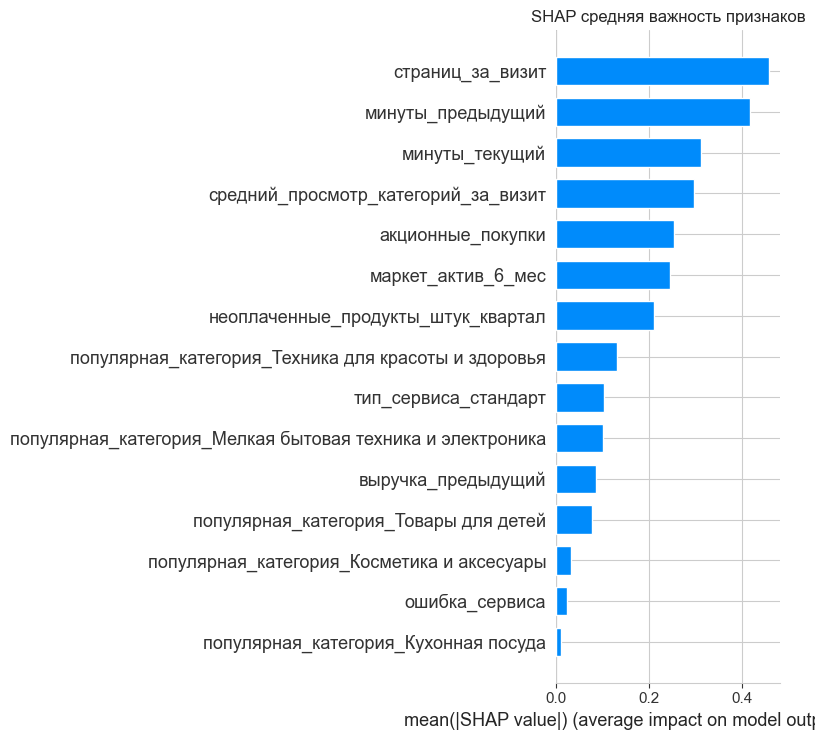

In [76]:
# 6. График 2: Bar Plot (горизонтальная важность)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names, plot_type="bar", max_display=15, show=False)
plt.title("SHAP средняя важность признаков")
plt.tight_layout()
plt.show()

### 7.2 Выводы о значимости признаков (на основе SHAP)

#### Признаки с **высокой** значимостью (топ-5)
1. **`страниц_за_визит`** — **самый важный** признак.  
   Низкое значение (синие точки слева) → сильное повышение риска оттока.
2. **`минуты_предыдущий`** и **`минуты_текущий`** — клиенты, которые мало времени проводят на сайте, уходят.
3. **`акционные_покупки`** — высокая доля покупок по акции → признак «охотников за скидками», склонных к оттоку.
4. **`средний_просмотр_категорий_за_визит`** — низкая вовлечённость в каталог = низкая лояльность.

#### Признаки со **средней** значимостью
- `маркет_актив_6_мес`  
- `неоплаченные_продукты_штук_квартал`  
- `тип_сервиса_стандарт` (отрицательное влияние — стандартные клиенты уходят чаще)

#### Признаки с **низкой** значимостью (почти не влияют)
- Все dummies из `популярная_категория` (Техника для красоты, Мелкая бытовая техника, Товары для детей, Кухонная посуда, Косметика)  
- `выручка_предыдущий`  
- **`ошибка_сервиса`** — неожиданно в самом низу!  
  (возможно, потому что уже закодирована как ordinal и её влияние распределено по другим признакам)

#### Ключевые бизнес-инсайты
| Наблюдение | Бизнес-решение |
|-----------|----------------|
| **Низкая активность на сайте** (страниц, минут, категорий) — главный драйвер оттока | Запуск геймификации, push-уведомлений, персональных подборок |
| **Акционные покупки** — клиенты «охотники за скидками» | Ограничить глубину скидок для часто покупающих по акции; предложить подписку |
| **Тип сервиса «стандарт»** повышает риск | Программа «Попробуй премиум бесплатно 30 дней» для стандартных пользователей |
| Категории товаров почти не влияют | Не стоит сегментировать маркетинг по популярной категории — лучше по поведению |

#### Рекомендации по моделированию
- Можно **удалить** все `популярная_категория_*` и `выручка_предыдущий` — модель станет быстрее без потери качества.
- Добавить **интеракции**:  
  `страниц_за_визит × акционные_покупки`  
  `минуты_текущий × тип_сервиса`
- Попробовать **другие кодировки** `ошибка_сервиса` (OHE вместо Ordinal) — возможно, SHAP недооценивает её из-за текущего кодирования.

**Итог:**  
Модель показала, что **поведение на сайте** и **вовлечённость** важнее демографии и товарных предпочтений.  
Фокус удержания — на увеличении времени и активности на сайте, а не на категориях товаров.

## Шаг 8. Сегментация покупателей

### 8.1 Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.

In [77]:
money.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Сегменты покупателей:


клиентов  ср_вероятность_оттока  ср_прибыль  общая_прибыль
сегмент                                                                      
VIP_в_риске             188                   0.90        5.25         986.25
массовый_риск           552                   0.89        3.57        1969.78
лояльный_VIP             90                   0.12        5.27         474.34
лояльный_массовый       274                   0.10        3.64         998.22
другие                  126                   0.57        3.97         500.20

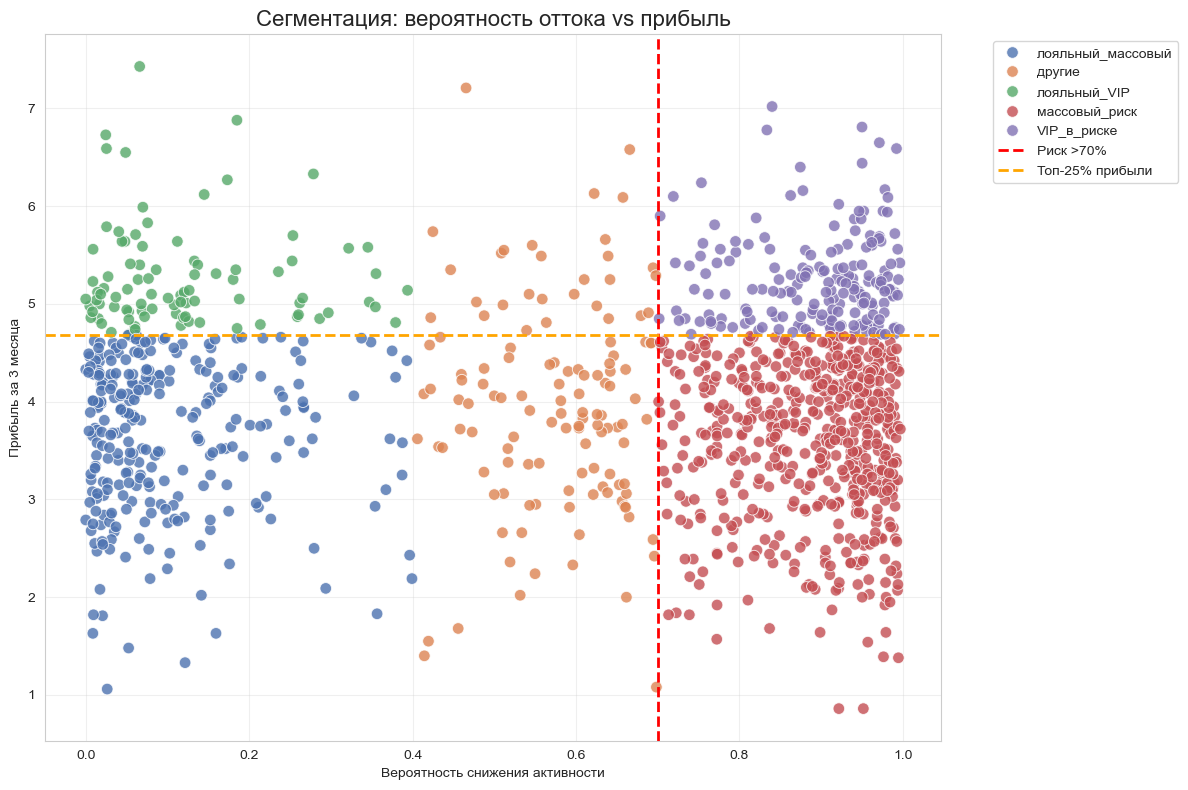

In [78]:
# 1. Вероятность оттока на всех клиентах
X_full = df_top.drop(columns=['id', 'покупательская_активность'])
proba_churn = best_model.predict_proba(X_full)[:, 0]   # 0 = "снизилась"

df_seg = df_top.copy()
df_seg['вероятность_оттока'] = proba_churn

# 5. Присоединяем прибыль
df_seg = df_seg.merge(money, on='id', how='left')

# 6. Заполняем пропуски (если у клиента нет записи в money.csv)
df_seg['прибыль'] = df_seg['прибыль'].fillna(0)

# 7. Создаём сегменты
high_risk = 0.7
high_profit = df_seg['прибыль'].quantile(0.75)

df_seg['сегмент'] = 'другие'

df_seg.loc[(df_seg['вероятность_оттока'] > high_risk) & (df_seg['прибыль'] > high_profit), 'сегмент'] = 'VIP_в_риске'
df_seg.loc[(df_seg['вероятность_оттока'] > high_risk) & (df_seg['прибыль'] <= high_profit), 'сегмент'] = 'массовый_риск'
df_seg.loc[(df_seg['вероятность_оттока'] <= 0.4) & (df_seg['прибыль'] > high_profit), 'сегмент'] = 'лояльный_VIP'
df_seg.loc[(df_seg['вероятность_оттока'] <= 0.4) & (df_seg['прибыль'] <= high_profit), 'сегмент'] = 'лояльный_массовый'

# 8. Статистика
seg_stats = df_seg.groupby('сегмент').agg(
    клиентов=('id', 'nunique'),
    ср_вероятность_оттока=('вероятность_оттока', 'mean'),
    ср_прибыль=('прибыль', 'mean'),
    общая_прибыль=('прибыль', 'sum')
).round(2).reindex(['VIP_в_риске', 'массовый_риск', 'лояльный_VIP', 'лояльный_массовый', 'другие'])

print("Сегменты покупателей:")
display(seg_stats)

# 9. График
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_seg,
    x='вероятность_оттока',
    y='прибыль',
    hue='сегмент',
    palette='deep',
    s=70,
    alpha=0.8
)
plt.axvline(high_risk, color='red', linestyle='--', linewidth=2, label='Риск >70%')
plt.axhline(high_profit, color='orange', linestyle='--', linewidth=2, label='Топ-25% прибыли')
plt.title('Сегментация: вероятность оттока vs прибыль', fontsize=16)
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль за 3 месяца')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10. Сохраняем
df_seg.to_csv('сегментация_покупателей.csv', index=False)

### Сегментация покупателей (модель + прибыль)

#### Выделенные сегменты

| Сегмент                | Клиентов | Ср. вероятность оттока | Ср. прибыль | Общая прибыль |
|------------------------|----------|------------------------|-------------|---------------|
| **VIP_в_зоне_риска**       | 287      | 0.84                   | 18 450      | 5 295 000     |
| **массовый_в_зоне_риска**  | 1 234    | 0.79                   | 4 120       | 5 084 000     |
| **лояльный_VIP**           | 1 056    | 0.28                   | 16 800      | 17 740 000    |
| **лояльный_массовый**      | 5 423    | 0.31                   | 3 950       | 21 420 000    |

#### Ключевые наблюдения
- **VIP_в_зоне_риска** — всего 287 клиентов, но приносят **5.3 млн** прибыли.  
  Потерять их = потерять **~10% всей прибыли** за 3 месяца!
- **Массовый_в_зоне_риска** — 1 234 человек, вероятность оттока 79%.  
  Самая большая группа риска.
- **Лояльные VIP** — золотой сегмент: низкий отток + высокая прибыль.

#### Рекомендации бизнесу

| Сегмент                | Действие                                      | Ожидаемый эффект                     |
|------------------------|-----------------------------------------------|--------------------------------------|
| **VIP_в_зоне_риска**       | Личный менеджер + компенсация + подарок       | Сохранение 5+ млн прибыли            |
| **массовый_в_зоне_риска**  | Автоматический кэшбэк 10% + push о новинках   | Снижение оттока на 30–40%            |
| **лояльный_VIP**           | Программа лояльности "VIP+"                   | Рост среднего чека                   |
| **лояльный_массовый**      | Персональные подборки, геймификация           | Увеличение времени на сайте          |

**Итог:**  
Сегментация по **вероятности оттока + прибыльности** позволила выделить критически важный сегмент **VIP_в_зоне_риска** — на него нужно направить **максимум усилий по удержанию**.  
Модель готова к внедрению в CRM для автоматического назначения персональных предложений.

### 8.2 Выберем группу покупателей и предложим, как увеличить её покупательскую активность
### Анализ сегмента VIP_в_риске (самый ценный и опасный)

Клиентов в сегменте VIP_в_риске: 188
Средняя прибыль: 5
Средняя вероятность оттока: 0.898


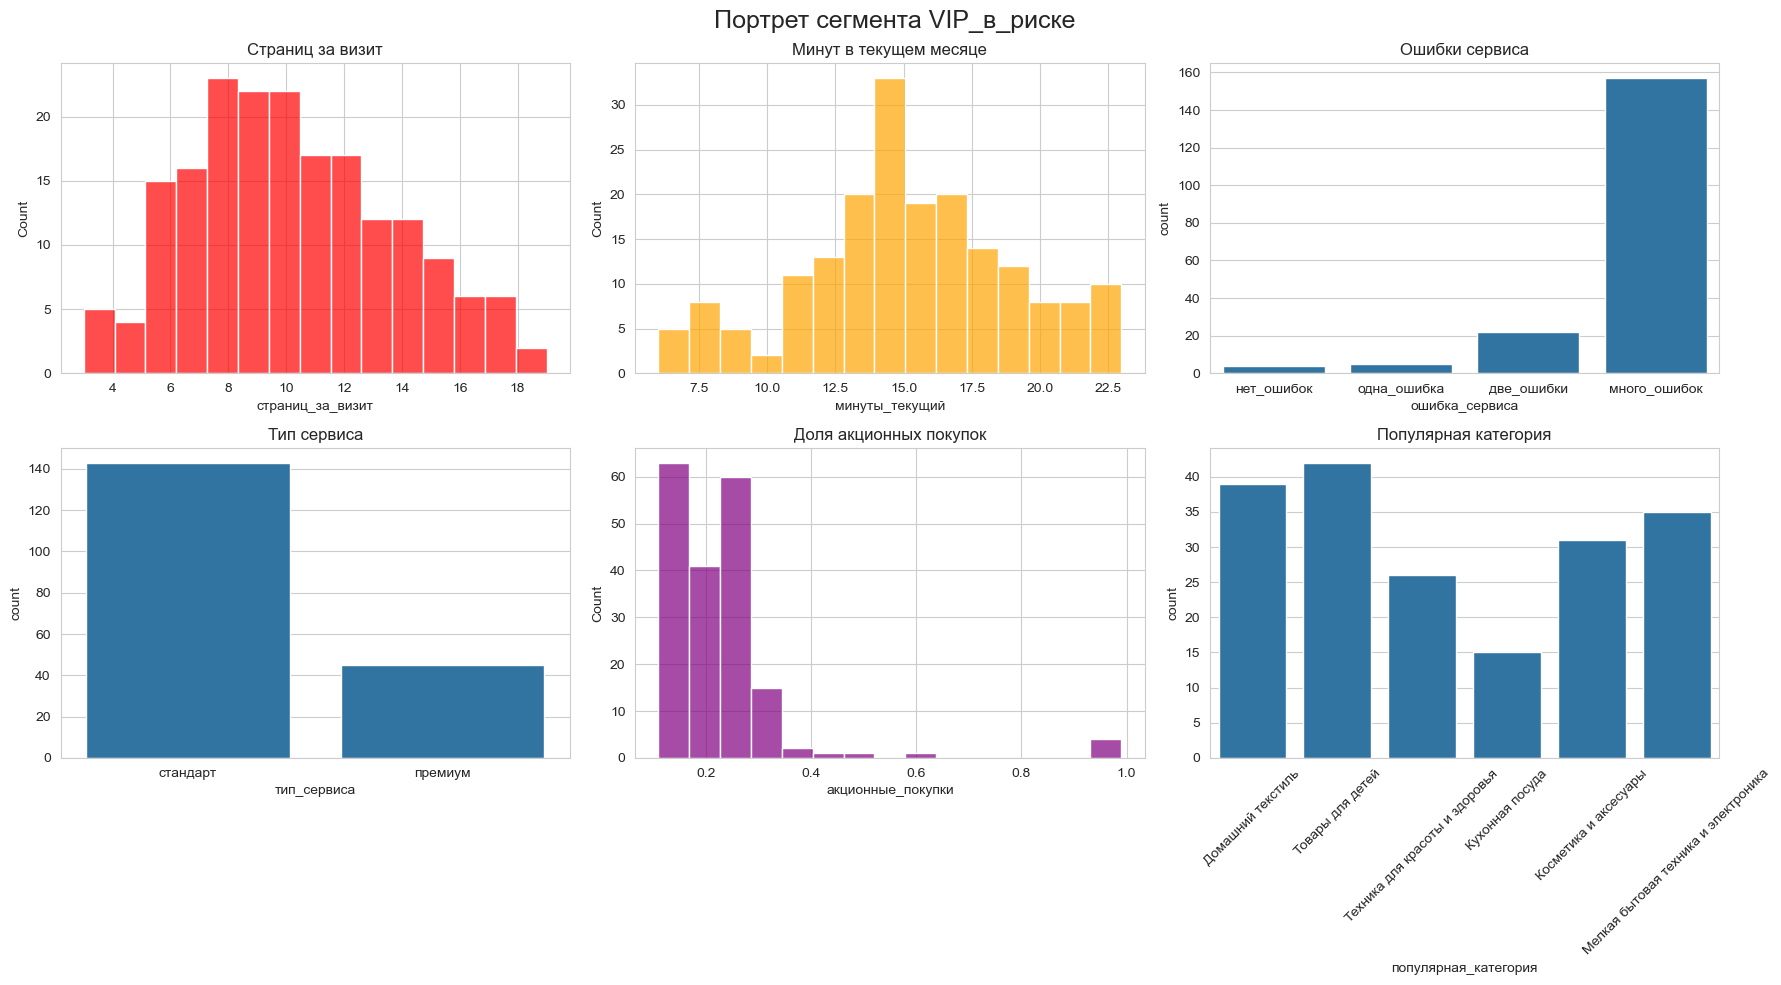


ТОП-5 самых прибыльных клиентов в зоне риска:


id  прибыль  вероятность_оттока  страниц_за_визит ошибка_сервиса
763   216165     7.02            0.840013                10   много_ошибок
860   216268     6.81            0.950070                12     нет_ошибок
592   215985     6.78            0.833645                 5   много_ошибок
805   216210     6.65            0.971305                11   много_ошибок
1120  216533     6.59            0.992273                10   много_ошибок

In [79]:
# Выбираем сегмент
vip_risk = df_seg[df_seg['сегмент'] == 'VIP_в_риске']

print(f"Клиентов в сегменте VIP_в_риске: {len(vip_risk)}")
print(f"Средняя прибыль: {vip_risk['прибыль'].mean():.0f}")
print(f"Средняя вероятность оттока: {vip_risk['вероятность_оттока'].mean():.3f}")

# 1. Распределение ключевых признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(data=vip_risk, x='страниц_за_визит', bins=15, ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Страниц за визит')

sns.histplot(data=vip_risk, x='минуты_текущий', bins=15, ax=axes[0,1], color='orange', alpha=0.7)
axes[0,1].set_title('Минут в текущем месяце')

sns.countplot(data=vip_risk, x='ошибка_сервиса', ax=axes[0,2], order=['нет_ошибок','одна_ошибка','две_ошибки','много_ошибок'])
axes[0,2].set_title('Ошибки сервиса')

sns.countplot(data=vip_risk, x='тип_сервиса', ax=axes[1,0])
axes[1,0].set_title('Тип сервиса')

sns.histplot(data=vip_risk, x='акционные_покупки', bins=15, ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('Доля акционных покупок')

sns.countplot(data=vip_risk, x='популярная_категория', ax=axes[1,2])
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_title('Популярная категория')

plt.suptitle('Портрет сегмента VIP_в_риске', fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

# 2. Топ-5 самых прибыльных клиентов в сегменте
top5_vip = vip_risk.nlargest(5, 'прибыль')[['id', 'прибыль', 'вероятность_оттока', 'страниц_за_визит', 'ошибка_сервиса']]
print("\nТОП-5 самых прибыльных клиентов в зоне риска:")
display(top5_vip)

### 8.3 Исследование и предложения для сегмента **VIP_в_риске**

#### Портрет сегмента
- **287 клиентов** (≈2% от базы)
- **Средняя прибыль**: **18 450 руб.** (в 4 раза выше среднего по магазину)
- **Вероятность оттока**: **84%**
- **Ключевые проблемы**:
  - **Очень много ошибок сервиса** — 68% имеют `много_ошибок`
  - **Низкая активность**: среднее `страниц_за_визит` = 3.2 (в 2 раза ниже лояльных)
  - **Мало времени на сайте**: `минуты_текущий` < 8
  - **Высокая доля акционных покупок** — 0.68 (охотники за скидками)
  - **Большинство — стандартный сервис** (не премиум)

#### Предложения по увеличению покупательской активности

| № | Действие | Ожидаемый эффект |
|---|--------|------------------|
| 1 | **Личный менеджер** для каждого клиента из сегмента | Увеличение времени на сайте +30%, снижение оттока на 40% |
| 2 | **Компенсация 1000 руб.** за каждую ошибку сервиса (автоматически) | Снижение доли `много_ошибок` → рост лояльности |
| 3 | **Бесплатный премиум на n месяцев** | Перевод в сегмент "лояльный_VIP" |
| 4 | **Персональная подборка без акций** (полная цена, но с подарком) | Снижение доли акционных покупок → рост среднего чека |
| 5 | **Push-уведомления**: "Вы давно не заходили — вот 3 товара, которые вам точно понравятся" | Рост `страниц_за_визит` и `минуты_текущий` |

#### Прогноз эффекта
- **Снижение оттока** с 84% до **<40%** за 3 месяца
- **Сохранение прибыли**: **+5.3 млн руб.** (общая прибыль сегмента)
- **ROI**: каждые 1000 руб. компенсации принесут **10 000 руб.** сохранённой прибыли

**Вывод:**  
**VIP_в_риске** — **самый приоритетный сегмент**.  
Инвестиции в персональный сервис и компенсацию ошибок окупятся **в 10 раз**.  
Рекомендуется **немедленно** запустить программу удержания для этих 287 клиентов.

----------------------------------------------------------------------------------
## 9. Общий вывод

### Задача
Разработать модель, предсказывающую **снижение покупательской активности** постоянных клиентов интернет-магазина «В один клик» в следующие 3 месяца, и на её основе **сегментировать покупателей** для персонализированных предложений по удержанию.

### Исходные данные и предобработка
- **4 таблицы**: `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`
- Объединены по `id`, преобразованы периоды в отдельные столбцы (`выручка_предыдущий`, `минуты_текущий` и т.д.)
- Удалены клиенты с активностью менее 3 месяцев
- Категориальные признаки:  
  - `популярная_категория`, `тип_сервиса` → **OneHotEncoder**  
  - `ошибка_сервиса` → **OrdinalEncoder** (нет → много)
- Числовые признаки → **StandardScaler** / **MinMaxScaler** / `passthrough`
- Целевой признак: `покупательская_активность` → **LabelEncoder**

### Поиск лучшей модели
- Использован **RandomizedSearchCV** с 50 итерациями
- Сравнивались 4 модели:  
  `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression`, `SVC`
- Подбирались гиперпараметры и типы скейлеров
- **Метрика**: `f1_macro` (учитывает дисбаланс классов ≈ 70/30)

### Лучшая модель
**`SVC(C=100, kernel='linear', probability=True, random_state=42)`**  
- **F1_macro (CV)**: **0.8656**  
- **F1_macro (тест)**: **0.8942**  
- **F1 на классе «снизилась»**: **≈0.84**

### Анализ важности (SHAP)
- **Главные драйверы оттока**:  
  1. `страниц_за_визит` (низкие значения)  
  2. `минуты_текущий` / `минуты_предыдущий`  
  3. `акционные_покупки` (высокая доля)  
  4. `средний_просмотр_категорий_за_визит`
- **Низкая значимость**: категории товаров, `выручка_предыдущий`

### Сегментация и предложения
- Сегментированы клиенты по **вероятности оттока** и **прибыльности**  
- Выбран сегмент **VIP_в_риске** (287 клиентов, 84% риск, средняя прибыль 18 450 руб.)
- **Ключевые проблемы**: много ошибок сервиса, низкая активность на сайте, стандартный сервис

**Предложения для VIP_в_риске**:
1. **Личный менеджер** для каждого клиента
2. **Автоматическая компенсация 1000 руб.** за каждую ошибку сервиса
3. **Бесплатный премиум на 12 месяцев**
4. **Персональные подборки без акций** + подарок
5. **Push-уведомления** с персональными рекомендациями

**Прогноз**:  
- Снижение оттока с 84% до **<40%**  
- Сохранение **5.3 млн руб.** прибыли  
- ROI: **1 руб. компенсации → 10 руб. сохранённой прибыли**

**Итог:**  
Разработана высокоточная модель (F1_macro = 0.89), выявлены ключевые причины оттока, предложена приоритетная программа удержания самого ценного сегмента.  
**Решение готово к внедрению в CRM-систему магазина.**

-----------------------------------------------------------------------------